In [1]:
# datapreprocessor.py

import pandas as pd
import numpy as np
from typing import List, Dict, Optional, Tuple, Any
import logging
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, SMOTEN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
import joblib  # For saving/loading transformers
from inspect import signature  # For parameter validation in SMOTE
from functools import wraps
import re

def dtw_path(s1: np.ndarray, s2: np.ndarray) -> list:
    """
    Compute the DTW cost matrix and return the optimal warping path.
    
    Args:
        s1: Sequence 1, shape (n, features)
        s2: Sequence 2, shape (m, features)
    
    Returns:
        path: A list of index pairs [(i, j), ...] indicating the alignment.
    """
    n, m = len(s1), len(s2)
    cost = np.full((n+1, m+1), np.inf)
    cost[0, 0] = 0

    # Build the cost matrix
    for i in range(1, n+1):
        for j in range(1, m+1):
            dist = np.linalg.norm(s1[i-1] - s2[j-1])
            cost[i, j] = dist + min(cost[i-1, j], cost[i, j-1], cost[i-1, j-1])

    # Backtracking to find the optimal path
    i, j = n, m
    path = []
    while i > 0 and j > 0:
        path.append((i-1, j-1))
        directions = [cost[i-1, j], cost[i, j-1], cost[i-1, j-1]]
        min_index = np.argmin(directions)
        if min_index == 0:
            i -= 1
        elif min_index == 1:
            j -= 1
        else:
            i -= 1
            j -= 1
    path.reverse()
    return path

def warp_sequence(seq: np.ndarray, path: list, target_length: int) -> np.ndarray:
    """
    Warp the given sequence to match the target length based on the DTW warping path.
    
    Args:
        seq: Original sequence, shape (n, features)
        path: Warping path from dtw_path (list of tuples)
        target_length: Desired sequence length (typically the reference length)
    
    Returns:
        aligned_seq: Warped sequence with shape (target_length, features)
    """
    aligned_seq = np.zeros((target_length, seq.shape[1]))
    # Create mapping: for each target index, collect corresponding indices from seq
    mapping = {t: [] for t in range(target_length)}
    for (i, j) in path:
        mapping[j].append(i)
    
    for t in range(target_length):
        indices = mapping[t]
        if indices:
            aligned_seq[t] = np.mean(seq[indices], axis=0)
        else:
            # If no alignment, reuse the previous value (or use interpolation)
            aligned_seq[t] = aligned_seq[t-1] if t > 0 else seq[0]
    return aligned_seq
    


class DataPreprocessor:
    def __init__(
        self,
        model_type: str,
        y_variable: List[str],
        ordinal_categoricals: List[str],
        nominal_categoricals: List[str],
        numericals: List[str],
        mode: str,  # 'train', 'predict', 'clustering'
        options: Optional[Dict] = None,
        debug: bool = False,
        normalize_debug: bool = False,
        normalize_graphs_output: bool = False,
        graphs_output_dir: str = './plots',
        transformers_dir: str = './transformers',
        # New time series parameters:
        time_column: Optional[str] = None,
        window_size: Optional[int] = None,
        horizon: Optional[int] = None,
        step_size: Optional[int] = None,
        max_sequence_length: Optional[int] = None,
        time_series_sequence_mode: str = "set_window",  # "set_window", "dtw", "pad", or "variable_length"
        sequence_categorical: Optional[List[str]] = None,
        # NEW: Secondary grouping for sub-phase segmentation (for DTW/pad modes)
        sequence_dtw_or_pad_categorical: Optional[List[str]] = None
    ):
        # --- Process and validate sequence grouping parameters ---
        self.sequence_categorical = list(sequence_categorical) if sequence_categorical else []
        self.sequence_dtw_or_pad_categorical = list(sequence_dtw_or_pad_categorical) if sequence_dtw_or_pad_categorical else []
        
        if set(self.sequence_categorical) & set(self.sequence_dtw_or_pad_categorical):
            conflicting = set(self.sequence_categorical) & set(self.sequence_dtw_or_pad_categorical)
            raise ValueError(f"Categorical conflict in {conflicting}. Top-level and sub-phase groups must form a strict hierarchy")

        self.model_type = model_type
        self.y_variable = y_variable
        self.ordinal_categoricals = ordinal_categoricals
        self.nominal_categoricals = nominal_categoricals
        self.numericals = numericals
        self.mode = mode.lower()
        if self.mode not in ['train', 'predict', 'clustering']:
            raise ValueError("Mode must be one of 'train', 'predict', or 'clustering'.")
        self.options = options or {}
        self.ts_outlier_method = self.options.get('handle_outliers', {}).get('time_series_method', 'median').lower()

        self.debug = debug
        self.normalize_debug = normalize_debug
        self.normalize_graphs_output = normalize_graphs_output
        self.graphs_output_dir = graphs_output_dir
        self.transformers_dir = transformers_dir

        # --- NEW: Time series parameters and mode-based validation ---
        self.time_column = time_column
        self.horizon = horizon
        self.max_sequence_length = max_sequence_length

        # Ensure the time_series_sequence_mode is lowercase for consistency
        self.time_series_sequence_mode = time_series_sequence_mode.lower()

        if self.time_series_sequence_mode == "set_window":
            # In "set_window" mode, both window_size and step_size are required.
            if window_size is None or step_size is None:
                raise ValueError("Both window_size and step_size are required for 'set_window' mode.")
            self.window_size = window_size
            self.step_size = step_size
        else:
            # For modes other than "set_window", ignore window_size/step_size parameters.
            if window_size is not None or step_size is not None:
                # Log a warning if the user provided these parameters unnecessarily.
                # Note: self.logger is initialized later; if you prefer, you can initialize it before this point.
                print("Warning: window_size/step_size parameters are ignored in non-'set_window' modes.")
            self.window_size = None
            self.step_size = None

        # ----------------------------------------------------
        # (The remaining initialization code remains unchanged)
        self.max_phase_distortion = self.options.get('max_phase_distortion', 0.3)  # 20% distortion allowed
        self.max_length_variance = self.options.get('max_length_variance', 5)  # allowable variation in phase lengths

        if self.sequence_categorical and self.sequence_dtw_or_pad_categorical:
            overlap = set(self.sequence_categorical) & set(self.sequence_dtw_or_pad_categorical)
            if overlap:
                raise ValueError(f"Overlapping grouping columns: {overlap}. Top-level and sub-phase groups must be distinct")

        # ... (initialize remaining attributes, logging, pipelines, etc.) ...
        self.hierarchical_categories = {}
        model_type_lower = self.model_type.lower()
        if any(kw in model_type_lower for kw in ['lstm', 'rnn', 'time series']):
            self.model_category = 'time_series'
        else:
            self.model_category = self.map_model_type_to_category()

        self.categorical_indices = []
        if self.model_category == 'unknown':
            self.logger = logging.getLogger(self.__class__.__name__)
            self.logger.error(f"Model category for '{self.model_type}' is unknown. Check your configuration.")
            raise ValueError(f"Model category for '{self.model_type}' is unknown. Check your configuration.")
        if self.mode in ['train', 'predict']:
            if not self.y_variable:
                raise ValueError("Target variable 'y_variable' must be specified for supervised models in train/predict mode.")
        elif self.mode == 'clustering':
            self.y_variable = []

        # NEW: Initialize follow-through metadata storage for debugging extreme durations.
        self.follow_through_stats = []  # Will store dicts with keys: group_key, phase, length (in seconds), num_rows
        self.time_step = self.options.get('time_step', 1/60) if self.options else 1/60

        # Initialize other variables (scalers, transformers, etc.)
        self.scaler = None
        self.transformer = None
        self.ordinal_encoder = None
        self.nominal_encoder = None
        self.preprocessor = None
        self.smote = None
        self.feature_reasons = {col: '' for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals}
        self.preprocessing_steps = []
        self.normality_results = {}
        self.features_to_transform = []
        self.nominal_encoded_feature_names = []
        self.final_feature_order = []

        # Additional initialization for clustering
        self.cluster_transformers = {}
        self.cluster_model = None
        self.cluster_labels = None
        self.silhouette_score = None

        # Default thresholds for SMOTE recommendations
        self.imbalance_threshold = self.options.get('smote_recommendation', {}).get('imbalance_threshold', 0.1)
        self.noise_threshold = self.options.get('smote_recommendation', {}).get('noise_threshold', 0.1)
        self.overlap_threshold = self.options.get('smote_recommendation', {}).get('overlap_threshold', 0.1)
        self.boundary_threshold = self.options.get('smote_recommendation', {}).get('boundary_threshold', 0.1)

        self.pipeline = None

        # Initialize logging
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.DEBUG if self.debug else logging.INFO)
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
        handler.setFormatter(formatter)
        if not self.logger.handlers:
            self.logger.addHandler(handler)

        # Initialize feature_reasons for clustering
        self.feature_reasons = {col: '' for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals}
        if self.model_category == 'clustering':
            self.feature_reasons['all_numericals'] = ''


    def get_debug_flag(self, flag_name: str) -> bool:
        """
        Retrieve the value of a specific debug flag from the options.
        Args:
            flag_name (str): The name of the debug flag.
        Returns:
            bool: The value of the debug flag.
        """
        return self.options.get(flag_name, False)

    def _log(self, message: str, step: str, level: str = 'info'):
        """
        Internal method to log messages based on the step-specific debug flags.
        
        Args:
            message (str): The message to log.
            step (str): The preprocessing step name.
            level (str): The logging level ('info', 'debug', etc.).
        """
        debug_flag = self.get_debug_flag(f'debug_{step}')
        if debug_flag:
            if level == 'debug':
                self.logger.debug(message)
            elif level == 'info':
                self.logger.info(message)
            elif level == 'warning':
                self.logger.warning(message)
            elif level == 'error':
                self.logger.error(message)

    def map_model_type_to_category(self) -> str:
        """
        Map the model_type string to a predefined category based on keywords.

        Returns:
            str: The model category ('classification', 'regression', 'clustering', etc.).
        """
        classification_keywords = ['classifier', 'classification', 'logistic', 'svm', 'support vector machine', 'knn', 'neural network']
        regression_keywords = ['regressor', 'regression', 'linear', 'knn', 'neural network']  # Removed 'svm'
        clustering_keywords = ['k-means', 'clustering', 'dbscan', 'kmodes', 'kprototypes']

        model_type_lower = self.model_type.lower()

        for keyword in classification_keywords:
            if keyword in model_type_lower:
                return 'classification'

        for keyword in regression_keywords:
            if keyword in model_type_lower:
                return 'regression'

        for keyword in clustering_keywords:
            if keyword in model_type_lower:
                return 'clustering'

        return 'unknown'

    def filter_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        step_name = "filter_columns"
        self.logger.info(f"Step: {step_name}")

        # Combine all feature lists from configuration
        desired_features = self.numericals + self.ordinal_categoricals + self.nominal_categoricals

        # For time series models, ensure the time column is included
        if self.model_category == 'time_series' and self.time_column:
            if self.time_column not in df.columns:
                self.logger.error(f"Time column '{self.time_column}' not found in input data.")
                raise ValueError(f"Time column '{self.time_column}' not found in the input data.")
            if self.time_column not in desired_features:
                desired_features.append(self.time_column)

        # Debug log: report target variable info
        self.logger.debug(f"y_variable provided: {self.y_variable}")
        if self.y_variable and all(col in df.columns for col in self.y_variable):
            self.logger.debug(f"First value in target column(s): {df[self.y_variable].iloc[0].to_dict()}")

        # For 'train' mode, ensure the target variable is present and excluded from features
        if self.mode == 'train':
            if not all(col in df.columns for col in self.y_variable):
                missing_y = [col for col in self.y_variable if col not in df.columns]
                self.logger.error(f"Target variable(s) {missing_y} not found in the input data.")
                raise ValueError(f"Target variable(s) {missing_y} not found in the input data.")
            desired_features = [col for col in desired_features if col not in self.y_variable]
            filtered_df = df[desired_features + self.y_variable].copy()
        else:
            filtered_df = df[desired_features].copy()

        # Check that all desired features are present in the input DataFrame
        missing_features = [col for col in desired_features if col not in df.columns]
        if missing_features:
            self.logger.error(f"The following required features are missing in the input data: {missing_features}")
            raise ValueError(f"The following required features are missing in the input data: {missing_features}")

        # Additional numeric type check for expected numeric columns
        for col in self.numericals:
            if col in filtered_df.columns and not np.issubdtype(filtered_df[col].dtype, np.number):
                raise TypeError(f"Numerical column '{col}' has non-numeric dtype {filtered_df[col].dtype}")

        self.logger.info(f"✅ Filtered DataFrame to include only specified features. Shape: {filtered_df.shape}")
        self.logger.debug(f"Selected Features: {desired_features}")
        if self.mode == 'train':
            self.logger.debug(f"Retained Target Variable(s): {self.y_variable}")

        return filtered_df



    def _group_top_level(self, data: pd.DataFrame):
        """
        Group the data based on top-level sequence categorical variables.
        Returns the grouped DataFrames (without converting them to NumPy arrays)
        to ensure that subsequent processing (such as sub-phase segmentation) has access
        to DataFrame methods like .groupby and .columns.
        """
        if not self.sequence_categorical:
            return [('default_group', data)]
        
        groups = data.groupby(self.sequence_categorical)
        self.logger.debug(f"Group keys: {list(groups.groups.keys())}")
        
        validated_groups = []
        for name, group in groups:
            try:
                self.logger.debug(f"Group '{name}' type: {type(group)}, Shape: {group.shape if hasattr(group, 'shape') else 'N/A'}")
            except Exception as e:
                self.logger.error(f"Error obtaining shape for group {name}: {e}")
            if isinstance(group, pd.DataFrame):
                # *** FIX: Return the DataFrame (not group.values) so that it retains the .columns attribute ***
                validated_groups.append((name, group))
            else:
                self.logger.warning(f"Unexpected group type {type(group)} for group {name}")
        return validated_groups




    @staticmethod
    def normalize_phase_key(key: str) -> str:
        """
        Normalize a phase key by:
          - Stripping leading/trailing whitespace.
          - Inserting an underscore between a lowercase letter and an uppercase letter.
          - Replacing spaces with underscores.
          - Converting the whole string to lowercase.
          
        This ensures that keys like "Arm Acceleration" and "ArmAcceleration" both normalize to "arm_acceleration".
        """
        key = key.strip()
        key = re.sub(r'(?<=[a-z])(?=[A-Z])', '_', key)  # insert underscore before uppercase letter if preceded by a lowercase
        key = key.replace(" ", "_")
        return key.lower()

        
    @staticmethod
    def safe_array_conversion(data):
        """
        Convert input data to a NumPy array if it is not already.
        Handles both structured and unstructured arrays.
        Raises a TypeError if the input data is a dictionary.
        """
        if isinstance(data, dict):
            raise TypeError("Input data is a dict. Expected array-like input.")
        if isinstance(data, np.ndarray):
            if data.dtype.names:
                # For structured arrays, view as float32 and reshape to combine fields.
                return data.view(np.float32).reshape(data.shape + (-1,))
            return data
        elif hasattr(data, 'values'):
            arr = data.values
            if arr.dtype.names:
                return arr.view(np.float32).reshape(arr.shape + (-1,))
            return arr
        else:
            return np.array(data)
            
    def _segment_subphases(self, group_data: pd.DataFrame, skip_min_samples=False):
        """
        Segment a group's data into sub-phases based on the secondary grouping.
        For each phase, convert to a NumPy array (after filtering to numeric columns)
        and store a tuple (original key, numeric array). The phase key is normalized
        using normalize_phase_key.
        
        Additional debugging:
        - Logs the raw keys obtained from groupby.
        - Logs the normalized phase keys and compares them with the expected keys.
        
        Args:
            group_data (pd.DataFrame): Data for one group.
            skip_min_samples (bool): If True, do not skip phases with very few samples.
        
        Returns:
            dict: Dictionary mapping normalized phase keys to tuples (original key, array).
        """
        # If no secondary grouping is provided, return a default phase.
        if not self.sequence_dtw_or_pad_categorical:
            if self.numericals:
                group_data = group_data[[col for col in group_data.columns if col in self.numericals]]
            return {"default_phase": ("default_phase", group_data.values)}
        
        phase_groups = list(group_data.groupby(self.sequence_dtw_or_pad_categorical))
        
        # Debug: log raw phase keys from groupby
        raw_keys = [group for group, _ in phase_groups]
        self.logger.debug(f"Raw phase keys in group: {raw_keys}")
        
        subphases = {}
        MIN_PHASE_SAMPLES = 5 if not skip_min_samples else 1  # Option: reduce minimum sample threshold
        
        if self.time_column and self.time_column in group_data.columns:
            try:
                self._validate_timestamps(group_data)
            except Exception as e:
                self.logger.warning(f"Timestamp validation error: {e}")

        for phase_key, phase_df in phase_groups:
            # Normalize key
            if isinstance(phase_key, tuple):
                stable_key = "|".join(map(str, phase_key))
            else:
                stable_key = str(phase_key)
            normalized_key = DataPreprocessor.normalize_phase_key(stable_key)
            self.logger.debug(f"Sub-phase raw key '{stable_key}' normalized to: '{normalized_key}'")
                            
            if not isinstance(phase_df, (pd.DataFrame, np.ndarray)):
                self.logger.error(f"Invalid type {type(phase_df)} for phase '{stable_key}'. Skipping.")
                continue

            phase_length = len(phase_df)
            self.logger.debug(f"Phase '{stable_key}' (normalized: '{normalized_key}') length: {phase_length}")

            if phase_length < MIN_PHASE_SAMPLES:
                self.logger.warning(f"Skipping short phase '{stable_key}' (length {phase_length} < {MIN_PHASE_SAMPLES})")
                continue

            # Convert to numeric array if necessary
            if isinstance(phase_df, pd.DataFrame):
                numeric_phase_df = phase_df[[col for col in phase_df.columns if col in self.numericals]] if self.numericals else phase_df
                try:
                    numeric_phase_array = self.safe_array_conversion(numeric_phase_df)
                except Exception as e:
                    self.logger.error(f"Array conversion failed for phase '{stable_key}': {e}")
                    continue
            elif isinstance(phase_df, np.ndarray):
                numeric_phase_array = phase_df
            else:
                self.logger.error(f"Unexpected type {type(phase_df)} for phase '{stable_key}'. Skipping.")
                continue

            # Ensure the array is 2D
            if numeric_phase_array.ndim == 1:
                numeric_phase_array = numeric_phase_array.reshape(-1, 1)
                self.logger.debug(f"Phase '{stable_key}' reshaped to 2D: {numeric_phase_array.shape}")

            subphases[normalized_key] = (stable_key, numeric_phase_array)
        
        self.logger.debug(f"Normalized phase keys obtained: {list(subphases.keys())}")
        expected = set(self.sequence_dtw_or_pad_categorical)
        self.logger.debug(f"Expected phase keys: {expected}")
        
        if not subphases:
            self.logger.error("No valid subphases detected in this group.")
            raise ValueError("Subphase segmentation produced an empty dictionary.")
        return subphases




    def _validate_timestamps(self, phase_data: pd.DataFrame):
        """
        Validate that timestamps in phase_data have no large discontinuities (>1 second gap).
        Logs a warning if a gap is detected.
        """
        time_col = self.time_column
        if time_col not in phase_data.columns:
            return
        diffs = phase_data[time_col].diff().dropna()
        if (diffs > 1.0).any():
            gap_loc = diffs.idxmax()
            self.logger.warning(
                f"Timestamp jump in group {getattr(phase_data, 'name', 'unknown')}: {diffs[gap_loc]:.2f}s gap at index {gap_loc}"
            )

    def _flag_extreme_phases(self, phase_stats):
        """
        Identify and log any extreme Follow-Through phases (duration > 30 seconds).
        """
        follow_throughs = [s for s in phase_stats if s["phase"] == "Follow Through"]
        if follow_throughs:
            max_ft = max(follow_throughs, key=lambda x: x["length"])
            if max_ft["length"] > 30:
                self.logger.error(
                    f"Extreme Follow-Through: group {max_ft['group_key']} length={max_ft['length']:.3f}s "
                    f"({max_ft['num_rows']} frames)"
                )

    def _log_top_outliers(self):
        """
        Log the top 5 longest Follow-Through durations from the recorded metadata.
        """
        if not self.follow_through_stats:
            self.logger.debug("No Follow-Through stats recorded.")
            return
        sorted_ft = sorted(self.follow_through_stats, key=lambda x: x["length"], reverse=True)[:5]
        self.logger.debug("Top 5 Follow-Through Durations:")
        for i, stats in enumerate(sorted_ft, 1):
            self.logger.debug(f"{i}. Group {stats['group_key']}: {stats['length']:.3f}s ({stats['num_rows']} frames)")

    def _filter_follow_through(self, phase_stats):
        """
        Dynamically filter groups based on Follow-Through duration.
        Discard a group if its Follow-Through duration exceeds mean + 5σ.
        """
        ft_lengths = [s["length"] for s in phase_stats if s["phase"] == "Follow Through"]
        if not ft_lengths:
            return True
        mean = np.mean(ft_lengths)
        std = np.std(ft_lengths)
        threshold = mean + 5 * std
        for stats in phase_stats:
            if stats["phase"] == "Follow Through" and stats["length"] > threshold:
                self.logger.warning(
                    f"Discarding group {stats['group_key']}: Follow-Through {stats['length']:.3f}s > 5σ ({threshold:.1f}s)"
                )
                return False
        return True


    @staticmethod
    def pad_sequence(seq: np.ndarray, target_length: int) -> np.ndarray:
        """
        Pad or truncate the given sequence to match the target length.
        Ensures that the input is a 2D array. For a 1D input, reshapes it to (-1, 1).
        A minimum target_length of 5 is enforced to avoid degenerate sequences.
        """
        seq = np.array(seq)
        if seq.ndim == 1:
            seq = seq.reshape(-1, 1)  # Ensure the array is 2D
        current_length = seq.shape[0]
        target_length = max(target_length, 5)  # Enforce a minimum target length of 5
        if current_length >= target_length:
            return seq[:target_length]
        else:
            pad_width = target_length - current_length
            padding = np.zeros((pad_width, seq.shape[1]))
            return np.concatenate([seq, padding], axis=0)


    def _align_phase(self, phase_data, target_length: int, phase_name: str) -> np.ndarray:
        """
        Align a sub-phase's sequence to a target length using DTW (if enabled) or padding.
        Validates that the resulting array is 2D and has exactly target_length rows.
        If DTW alignment results in an array of incorrect shape, falls back to padding.
        """
        if isinstance(phase_data, pd.DataFrame):
            phase_data = phase_data[[col for col in phase_data.columns if col in self.numericals]] if self.numericals else phase_data.copy()

        if isinstance(phase_data, dict):
            self.logger.error(f"Received dict instead of array. Keys: {list(phase_data.keys())}")
            raise TypeError("Phase data must be array-like, not dict. Check your grouping logic.")

        phase_array = self.safe_array_conversion(phase_data)
        self.logger.debug(f"Aligning phase '{phase_name}' with input type {type(phase_data)} and shape {phase_array.shape}")

        if phase_array.ndim == 1:
            phase_array = phase_array.reshape(1, -1)
            self.logger.debug(f"Phase '{phase_name}' was 1D and has been reshaped to {phase_array.shape}")

        current_length = phase_array.shape[0]

        if phase_array.ndim != 2:
            self.logger.error(f"Invalid input shape {phase_array.shape} - expected a 2D array")
            raise ValueError("DTW alignment requires a 2D array input")
        
        if not np.issubdtype(phase_array.dtype, np.number):
            self.logger.warning(f"Non-numeric dtype detected: {phase_array.dtype}. Converting to np.float32.")
            try:
                phase_array = phase_array.astype(np.float32)
            except Exception as e:
                self.logger.error(f"Failed conversion to float32: {e}")
                raise

        try:
            if self.time_series_sequence_mode == "dtw":
                distortion = abs(current_length - target_length) / target_length
                self.logger.debug(f"[Distortion Analysis] Phase '{phase_name}': raw length {current_length} vs target {target_length} | Distortion: {distortion:.1%}")
                MAX_DISTORTION = 0.2
                if distortion > MAX_DISTORTION:
                    raise ValueError(f"Excessive DTW distortion {distortion:.1%} exceeds threshold of {MAX_DISTORTION:.0%}")
                alignment_path = dtw_path(phase_array, phase_array)
                aligned_seq = warp_sequence(phase_array, alignment_path, target_length)
            else:
                aligned_seq = self.pad_sequence(phase_array, target_length)
        except Exception as e:
            self.logger.warning(f"Alignment failed for phase '{phase_name}': {e}. Falling back to padding.")
            aligned_seq = self.pad_sequence(phase_array, target_length)

        if aligned_seq.shape[0] != target_length:
            self.logger.error(f"Phase '{phase_name}' alignment resulted in {aligned_seq.shape[0]} steps (expected {target_length}).")
            raise ValueError(f"Alignment for phase '{phase_name}' did not yield exactly {target_length} steps.")

        self.logger.debug(f"Phase '{phase_name}' aligned successfully to shape {aligned_seq.shape}")
        return aligned_seq



    def _validate_sequences(self, aligned_sequences: dict):
        """
        Validate that each group in aligned_sequences has a consistent total length.
        Also, dynamically filter out groups with extreme Follow-Through durations.
        """
        if not isinstance(aligned_sequences, (dict, list)):
            self.logger.error(f"Invalid sequence container type {type(aligned_sequences)}")
        
        if isinstance(aligned_sequences, dict):
            valid_sequences = {k: v for k, v in aligned_sequences.items() if isinstance(v, dict)}
        else:
            valid_sequences = aligned_sequences

        # Check individual phase shapes within each group.
        for group_key, phases in aligned_sequences.items():
            for phase_name, phase_data in phases.items():
                if not hasattr(phase_data, 'shape'):
                    self.logger.error(f"In group {group_key}, phase '{phase_name}' is of type {type(phase_data)}; expected an array with a 'shape' attribute.")
                    raise TypeError(f"In group {group_key}, phase '{phase_name}' is not a valid array (has type {type(phase_data)}).")
            shapes = [phase.shape for phase in phases.values() if phase is not None]
            if len(set(shapes)) > 1:
                self.logger.error(f"Inconsistent phase shapes in group {group_key}: {shapes}")
        
        return aligned_sequences



    def post_processing_report(self):
        """
        Generate a post-processing report of Follow-Through statistics after filtering.
        """
        ft_lengths = [s["length"] for s in self.follow_through_stats if s["phase"] == "Follow Through"]
        if ft_lengths:
            report = (
                f"Follow-Through Stats After Filtering:\n"
                f"- Min: {min(ft_lengths):.3f}s\n"
                f"- Max: {max(ft_lengths):.3f}s\n"
                f"- σ: {np.std(ft_lengths):.3f}s"
            )
            self.logger.info(report)
        else:
            self.logger.info("No Follow-Through phases recorded.")



    def _filter_sequences(self, sequences: dict):
        """
        Filter sequences by ensuring that within each group the ratio of valid (non-None) phases is acceptable.
        Raises an error if more than 30% of sequences in any group are invalid.
        """
        valid_sequences = {}
        for seq_id, phases in sequences.items():
            valid_phases = [p for p in phases.values() if p is not None]
            if len(valid_phases) / len(phases) < 0.7:
                raise ValueError(f"Over 30% of phases in sequence {seq_id} are invalid.")
            valid_sequences[seq_id] = phases
        return valid_sequences

    def _apply_smote_ts(self, aligned_data):
        """
        If the option 'apply_smote_ts' is enabled, apply SMOTE-TS to balance the sequences temporally.
        Assumes the existence of a SMOTE_TS class and a _detect_phase_transitions helper.
        """
        if not self.options.get('apply_smote_ts'):
            return aligned_data
        
        phase_boundaries = self._detect_phase_transitions(aligned_data)  # You must implement this helper as needed.
        smote = SMOTE_TS(
            phases=self.sequence_dtw_or_pad_categorical,
            dtw_window=int(self.max_phase_distortion * 100),  # Converts the distortion to sample count (example)
            phase_markers=phase_boundaries
        )
        return smote.fit_resample(aligned_data)

    def _verify_temporal_flow(self, sequence):
        """
        Check that the sequence has valid phase transitions.
        Assumes existence of a list/dict VALID_TRANSITIONS.
        """
        transitions = detect_phase_transitions(sequence)  # Implement or import detect_phase_transitions as needed.
        if not all(t in VALID_TRANSITIONS for t in transitions):
            raise ValueError("Impossible phase sequence detected")
        return True




    def _validate_distributions(self, pre, post):
        """
        Run KS-tests on numerical features to ensure that distributions remain similar after alignment.
        """
        import scipy.stats
        ks_tests = {}
        for feature in self.numericals:
            ks = scipy.stats.ks_2samp(pre[:, feature], post[:, feature])
            if ks.pvalue < 0.01:
                self.logger.warning(f"Distribution changed significantly for {feature}")
            ks_tests[feature] = ks
        return ks_tests


    def create_sequences_by_category(self, X: np.ndarray, y: np.ndarray, group_ids: np.ndarray) -> Tuple[Any, Any, np.ndarray]:
        # Convert group_ids to tuple keys if more than one grouping column is provided.
        if group_ids.ndim > 1:
            group_keys_full = np.array([tuple(row) for row in group_ids])
        else:
            group_keys_full = group_ids

        unique_groups = np.unique(group_keys_full, axis=0)
        sequences_X = []
        sequences_y = []
        group_keys_list = []
        
        for idx, group in enumerate(unique_groups):
            if group_keys_full.ndim > 1:
                indices = np.where(np.all(group_keys_full == group, axis=1))[0]
            else:
                indices = np.where(group_keys_full == group)[0]
            seq_X = X[indices, :]
            seq_y = y[indices]
            sequences_X.append(seq_X)
            sequences_y.append(seq_y)
            group_keys_list.append(group)
            self.logger.debug(f"Group {group} - seq_y shape: {seq_y.shape}")

        if self.time_series_sequence_mode in ["dtw", "pad"]:
            max_length = max(seq.shape[0] for seq in sequences_X)
            self.logger.debug(f"Maximum sequence length determined: {max_length}")
        # For "variable_length", we leave sequences as they are.

        aligned_X = []
        aligned_y = []
        
        for idx, (seq_X, seq_y) in enumerate(zip(sequences_X, sequences_y)):
            current_length = seq_X.shape[0]
            if self.time_series_sequence_mode == "dtw" and current_length < max_length:
                self.logger.debug(f"Group {unique_groups[idx]}: applying DTW warping. Original shape: {seq_X.shape}")
                original_seq = seq_X.copy()
                path = dtw_path(seq_X, seq_X)
                seq_X_aligned = warp_sequence(seq_X, path, max_length)
                pad_width = max_length - current_length
                seq_y_aligned = np.pad(seq_y, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
                aligned_X.append(seq_X_aligned)
                aligned_y.append(seq_y_aligned)
            elif self.time_series_sequence_mode == "pad" and current_length < max_length:
                self.logger.debug(f"Group {unique_groups[idx]}: applying zero padding. Original shape: {seq_X.shape}")
                pad_width = max_length - current_length
                seq_X_aligned = np.pad(seq_X, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
                seq_y_aligned = np.pad(seq_y, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
                aligned_X.append(seq_X_aligned)
                aligned_y.append(seq_y_aligned)
            else:
                aligned_X.append(seq_X)
                aligned_y.append(seq_y)
        
        if self.time_series_sequence_mode == "variable_length":
            X_seq = aligned_X
            y_seq = aligned_y
        else:
            X_seq = np.array(aligned_X)
            y_seq = np.array(aligned_y)
        
        return X_seq, y_seq, np.array(group_keys_list)




    def apply_dtw_alignment(self, sequences: np.ndarray) -> np.ndarray:
        """
        Align a set of sequences using DTW so that all sequences match the reference length.
        
        Args:
            sequences: Array of sequences with shape (num_sequences, seq_length, num_features)
        
        Returns:
            aligned_sequences: Array of DTW-aligned sequences.
        """
        ref = sequences[0]
        target_length = ref.shape[0]
        aligned_sequences = []
        
        for seq in sequences:
            path = dtw_path(seq, ref)
            aligned_seq = warp_sequence(seq, path, target_length)
            aligned_sequences.append(aligned_seq)
        
        return np.array(aligned_sequences)

    def create_sequences(self, X: np.ndarray, y: np.ndarray) -> Tuple[Any, Any]:
        X_seq, y_seq = [], []
        if self.time_series_sequence_mode == "set_window":
            # Sliding window approach
            for i in range(0, len(X) - self.window_size - self.horizon + 1, self.step_size):
                seq_X = X[i:i+self.window_size]
                seq_y = y[i+self.window_size:i+self.window_size+self.horizon]
                if self.max_sequence_length and seq_X.shape[0] < self.max_sequence_length:
                    pad_width = self.max_sequence_length - seq_X.shape[0]
                    seq_X = np.pad(seq_X, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
                X_seq.append(seq_X)
                y_seq.append(seq_y)
        
        elif self.time_series_sequence_mode in ["dtw", "pad", "variable_length"]:
            # Full sequence processing
            X_seq = X
            y_seq = y
        
        else:
            raise ValueError(f"Unsupported time_series_sequence_mode: {self.time_series_sequence_mode}")

        return np.array(X_seq), np.array(y_seq)




    def temporal_encode_sequences(self, X_seq: Any, group_keys: np.ndarray) -> Any:
        if group_keys.ndim == 1:
            group_keys = group_keys.reshape(-1, 1)
        num_group = group_keys.shape[1]
        for i in range(num_group):
            col_name = self.sequence_categorical[i] if isinstance(self.sequence_categorical, list) else self.sequence_categorical
            if col_name not in self.hierarchical_categories or not self.hierarchical_categories[col_name]:
                self.hierarchical_categories[col_name] = sorted(np.unique(group_keys[:, i]))
                self.logger.debug(f"Hierarchical categories for '{col_name}': {self.hierarchical_categories[col_name]}")
        
        encoded_sequences = []
        for idx, seq in enumerate(X_seq):
            seq_length = seq.shape[0]
            pos_encoding = np.linspace(0, 1, seq_length).reshape(-1, 1)
            if group_keys.shape[1] == 1:
                group_value = group_keys[idx, 0]
                col_name = self.sequence_categorical[0] if isinstance(self.sequence_categorical, list) else self.sequence_categorical
                categories = self.hierarchical_categories[col_name]
                one_hot = np.zeros((seq_length, len(categories)))
                if group_value in categories:
                    one_hot[:, categories.index(group_value)] = 1
                else:
                    self.logger.warning(f"Group key {group_value} not found in categories for '{col_name}'.")
            else:
                one_hot_list = []
                for i in range(group_keys.shape[1]):
                    col_name = self.sequence_categorical[i] if isinstance(self.sequence_categorical, list) else self.sequence_categorical
                    categories = self.hierarchical_categories[col_name]
                    group_value = group_keys[idx, i]
                    one_hot_col = np.zeros((seq_length, len(categories)))
                    if group_value in categories:
                        one_hot_col[:, categories.index(group_value)] = 1
                    else:
                        self.logger.warning(f"Group value {group_value} not found in categories for '{col_name}'.")
                    one_hot_list.append(one_hot_col)
                one_hot = np.concatenate(one_hot_list, axis=1)
        
            seq_encoded = np.concatenate([seq, one_hot, pos_encoding], axis=1)
            encoded_sequences.append(seq_encoded)
        
        if self.time_series_sequence_mode != "variable_length":
            encoded_sequences = np.array(encoded_sequences)
        return encoded_sequences




    def split_dataset(
        self,
        X: pd.DataFrame,
        y: Optional[pd.Series] = None
    ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.Series], Optional[pd.Series]]:
        """
        Split the dataset into training and testing sets while retaining original indices.

        Args:
            X (pd.DataFrame): Features.
            y (Optional[pd.Series]): Target variable.

        Returns:
            Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.Series], Optional[pd.Series]]: X_train, X_test, y_train, y_test
        """
        step_name = "split_dataset"
        self.logger.info("Step: Split Dataset into Train and Test")

        # Debugging Statements
        self._log(f"Before Split - X shape: {X.shape}", step_name, 'debug')
        if y is not None:
            self._log(f"Before Split - y shape: {y.shape}", step_name, 'debug')
        else:
            self._log("Before Split - y is None", step_name, 'debug')

        # Determine splitting based on mode
        if self.mode == 'train' and self.model_category in ['classification', 'regression']:
            if self.model_category == 'classification':
                stratify = y if self.options.get('split_dataset', {}).get('stratify_for_classification', False) else None
                test_size = self.options.get('split_dataset', {}).get('test_size', 0.2)
                random_state = self.options.get('split_dataset', {}).get('random_state', 42)
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, 
                    test_size=test_size,
                    stratify=stratify, 
                    random_state=random_state
                )
                self._log("Performed stratified split for classification.", step_name, 'debug')
            elif self.model_category == 'regression':
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, 
                    test_size=self.options.get('split_dataset', {}).get('test_size', 0.2),
                    random_state=self.options.get('split_dataset', {}).get('random_state', 42)
                )
                self._log("Performed random split for regression.", step_name, 'debug')
        else:
            # For 'predict' and 'clustering' modes or other categories
            X_train = X.copy()
            X_test = None
            y_train = y.copy() if y is not None else None
            y_test = None
            self.logger.info(f"No splitting performed for mode '{self.mode}' or model category '{self.model_category}'.")

        self.preprocessing_steps.append("Split Dataset into Train and Test")

        # Keep Indices Aligned Through Each Step
        if X_test is not None and y_test is not None:
            # Sort both X_test and y_test by index
            X_test = X_test.sort_index()
            y_test = y_test.sort_index()
            self.logger.debug("Sorted X_test and y_test by index for alignment.")

        # Debugging: Log post-split shapes and index alignment
        self._log(f"After Split - X_train shape: {X_train.shape}, X_test shape: {X_test.shape if X_test is not None else 'N/A'}", step_name, 'debug')
        if self.model_category == 'classification' and y_train is not None and y_test is not None:
            self.logger.debug(f"Class distribution in y_train:\n{y_train.value_counts(normalize=True)}")
            self.logger.debug(f"Class distribution in y_test:\n{y_test.value_counts(normalize=True)}")
        elif self.model_category == 'regression' and y_train is not None and y_test is not None:
            self.logger.debug(f"y_train statistics:\n{y_train.describe()}")
            self.logger.debug(f"y_test statistics:\n{y_test.describe()}")

        # Check index alignment
        if y_train is not None and X_train.index.equals(y_train.index):
            self.logger.debug("X_train and y_train indices are aligned.")
        else:
            self.logger.warning("X_train and y_train indices are misaligned.")

        if X_test is not None and y_test is not None and X_test.index.equals(y_test.index):
            self.logger.debug("X_test and y_test indices are aligned.")
        elif X_test is not None and y_test is not None:
            self.logger.warning("X_test and y_test indices are misaligned.")

        return X_train, X_test, y_train, y_test

    def handle_missing_values(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Handle missing values for numerical and categorical features based on user options.
        """
        step_name = "handle_missing_values"
        self.logger.info("Step: Handle Missing Values")

        # Fetch user-defined imputation options or set defaults
        impute_options = self.options.get('handle_missing_values', {})
        numerical_strategy = impute_options.get('numerical_strategy', {})
        categorical_strategy = impute_options.get('categorical_strategy', {})

        # Numerical Imputation
        numerical_imputer = None
        new_columns = []
        if self.numericals:
            if self.model_category in ['regression', 'classification', 'clustering']:
                default_num_strategy = 'median'  # Changed to median as per preprocessor_config.yaml
            else:
                default_num_strategy = 'median'
            num_strategy = numerical_strategy.get('strategy', default_num_strategy)
            num_imputer_type = numerical_strategy.get('imputer', 'SimpleImputer')  # Can be 'SimpleImputer', 'KNNImputer', etc.

            self._log(f"Numerical Imputation Strategy: {num_strategy.capitalize()}, Imputer Type: {num_imputer_type}", step_name, 'debug')

            # Initialize numerical imputer based on user option
            if num_imputer_type == 'SimpleImputer':
                numerical_imputer = SimpleImputer(strategy=num_strategy)
            elif num_imputer_type == 'KNNImputer':
                knn_neighbors = numerical_strategy.get('knn_neighbors', 5)
                numerical_imputer = KNNImputer(n_neighbors=knn_neighbors)
            else:
                self.logger.error(f"Numerical imputer type '{num_imputer_type}' is not supported.")
                raise ValueError(f"Numerical imputer type '{num_imputer_type}' is not supported.")

            # Fit and transform ONLY on X_train
            X_train[self.numericals] = numerical_imputer.fit_transform(X_train[self.numericals])
            self.numerical_imputer = numerical_imputer  # Assign to self for saving
            self.feature_reasons.update({col: self.feature_reasons.get(col, '') + f'Numerical: {num_strategy.capitalize()} Imputation | ' for col in self.numericals})
            new_columns.extend(self.numericals)

            if X_test is not None:
                # Transform ONLY on X_test without fitting
                X_test[self.numericals] = numerical_imputer.transform(X_test[self.numericals])

        # Categorical Imputation
        categorical_imputer = None
        all_categoricals = self.ordinal_categoricals + self.nominal_categoricals
        if all_categoricals:
            default_cat_strategy = 'most_frequent'
            cat_strategy = categorical_strategy.get('strategy', default_cat_strategy)
            cat_imputer_type = categorical_strategy.get('imputer', 'SimpleImputer')

            self._log(f"Categorical Imputation Strategy: {cat_strategy.capitalize()}, Imputer Type: {cat_imputer_type}", step_name, 'debug')

            # Initialize categorical imputer based on user option
            if cat_imputer_type == 'SimpleImputer':
                categorical_imputer = SimpleImputer(strategy=cat_strategy)
            elif cat_imputer_type == 'ConstantImputer':
                fill_value = categorical_strategy.get('fill_value', 'Missing')
                categorical_imputer = SimpleImputer(strategy='constant', fill_value=fill_value)
            else:
                self.logger.error(f"Categorical imputer type '{cat_imputer_type}' is not supported.")
                raise ValueError(f"Categorical imputer type '{cat_imputer_type}' is not supported.")

            # Fit and transform ONLY on X_train
            X_train[all_categoricals] = categorical_imputer.fit_transform(X_train[all_categoricals])
            self.categorical_imputer = categorical_imputer  # Assign to self for saving
            self.feature_reasons.update({
                col: self.feature_reasons.get(col, '') + (f'Categorical: Constant Imputation (Value={categorical_strategy.get("fill_value", "Missing")}) | ' if cat_imputer_type == 'ConstantImputer' else f'Categorical: {cat_strategy.capitalize()} Imputation | ')
                for col in all_categoricals
            })
            new_columns.extend(all_categoricals)

            if X_test is not None:
                # Transform ONLY on X_test without fitting
                X_test[all_categoricals] = categorical_imputer.transform(X_test[all_categoricals])

        self.preprocessing_steps.append("Handle Missing Values")

        # Debugging: Log post-imputation shapes and missing values
        self._log(f"Completed: Handle Missing Values. Dataset shape after imputation: {X_train.shape}", step_name, 'debug')
        self._log(f"Missing values after imputation in X_train:\n{X_train.isnull().sum()}", step_name, 'debug')
        self._log(f"New columns handled: {new_columns}", step_name, 'debug')

        return X_train, X_test

    def handle_outliers(self, X_train: pd.DataFrame, y_train: Optional[pd.Series] = None) -> Tuple[pd.DataFrame, Optional[pd.Series]]:
        """
        Handle outliers based on the model's sensitivity and user options.
        For time_series models, apply a custom outlier handling using a rolling statistic (median or mean)
        to replace extreme values rather than dropping rows (to preserve temporal alignment).

        Args:
            X_train (pd.DataFrame): Training features.
            y_train (pd.Series, optional): Training target.

        Returns:
            tuple: X_train with outliers handled and corresponding y_train.
        """
        step_name = "handle_outliers"
        self.logger.info("Step: Handle Outliers")
        self._log("Starting outlier handling.", step_name, 'debug')
        initial_shape = X_train.shape[0]
        outlier_options = self.options.get('handle_outliers', {})
        zscore_threshold = outlier_options.get('zscore_threshold', 3)
        iqr_multiplier = outlier_options.get('iqr_multiplier', 1.5)
        isolation_contamination = outlier_options.get('isolation_contamination', 0.05)

        # ----- NEW: Configurable outlier handling branch for time series -----
        if self.model_category == 'time_series':
            # Check if time series outlier handling is disabled
            if self.ts_outlier_method == 'none':
                self.logger.info("Time series outlier handling disabled per config")
                return X_train, y_train

            # Validate that the method is one of the allowed options
            valid_methods = ['median', 'mean']
            if self.ts_outlier_method not in valid_methods:
                raise ValueError(f"Invalid ts_outlier_method: {self.ts_outlier_method}. Choose from {valid_methods + ['none']}")

            self.logger.info(f"Applying {self.ts_outlier_method}-based outlier replacement for time series")
            
            # Process each numerical column using the selected method
            for col in self.numericals:
                # Dynamic method selection based on configuration
                if self.ts_outlier_method == 'median':
                    rolling_stat = X_train[col].rolling(window=5, center=True, min_periods=1).median()
                elif self.ts_outlier_method == 'mean':
                    rolling_stat = X_train[col].rolling(window=5, center=True, min_periods=1).mean()
                
                # Compute rolling IQR for outlier detection
                rolling_q1 = X_train[col].rolling(window=5, center=True, min_periods=1).quantile(0.25)
                rolling_q3 = X_train[col].rolling(window=5, center=True, min_periods=1).quantile(0.75)
                rolling_iqr = rolling_q3 - rolling_q1
                
                # Create an outlier mask based on deviation from the rolling statistic
                outlier_mask = abs(X_train[col] - rolling_stat) > (iqr_multiplier * rolling_iqr)
                
                # Replace detected outliers with the corresponding rolling statistic
                X_train.loc[outlier_mask, col] = rolling_stat[outlier_mask]
                self.logger.debug(f"Replaced {outlier_mask.sum()} outliers in column '{col}' using {self.ts_outlier_method} method.")
            
            self.preprocessing_steps.append("Handle Outliers (time_series custom)")
            self._log(f"Completed: Handle Outliers for time_series. Initial samples: {initial_shape}, Final samples: {X_train.shape[0]}", step_name, 'debug')
            return X_train, y_train
        # -----------------------------------------------------------------

        # Existing outlier handling for regression and classification models
        if self.model_category in ['regression', 'classification']:
            self.logger.info(f"Applying univariate outlier detection for {self.model_category}.")
            for col in self.numericals:
                # Z-Score Filtering
                apply_zscore = outlier_options.get('apply_zscore', True)
                if apply_zscore:
                    z_scores = np.abs((X_train[col] - X_train[col].mean()) / X_train[col].std())
                    mask_z = z_scores < zscore_threshold
                    removed_z = (~mask_z).sum()
                    X_train = X_train[mask_z]
                    if y_train is not None:
                        y_train = y_train.loc[X_train.index]
                    self.feature_reasons[col] += f'Outliers handled with Z-Score Filtering (threshold={zscore_threshold}) | '
                    self._log(f"Removed {removed_z} outliers from '{col}' using Z-Score Filtering.", step_name, 'debug')

                # IQR Filtering
                apply_iqr = outlier_options.get('apply_iqr', True)
                if apply_iqr:
                    Q1 = X_train[col].quantile(0.25)
                    Q3 = X_train[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - iqr_multiplier * IQR
                    upper_bound = Q3 + iqr_multiplier * IQR
                    mask_iqr = (X_train[col] >= lower_bound) & (X_train[col] <= upper_bound)
                    removed_iqr = (~mask_iqr).sum()
                    X_train = X_train[mask_iqr]
                    if y_train is not None:
                        y_train = y_train.loc[X_train.index]
                    self.feature_reasons[col] += f'Outliers handled with IQR Filtering (multiplier={iqr_multiplier}) | '
                    self._log(f"Removed {removed_iqr} outliers from '{col}' using IQR Filtering.", step_name, 'debug')

        elif self.model_category == 'clustering':
            self.logger.info("Applying multivariate IsolationForest for clustering.")
            contamination = isolation_contamination
            iso_forest = IsolationForest(contamination=contamination, random_state=42)
            preds = iso_forest.fit_predict(X_train[self.numericals])
            mask_iso = preds != -1
            removed_iso = (preds == -1).sum()
            X_train = X_train[mask_iso]
            if y_train is not None:
                y_train = y_train.loc[X_train.index]
            self.feature_reasons['all_numericals'] += f'Outliers handled with Multivariate IsolationForest (contamination={contamination}) | '
            self._log(f"Removed {removed_iso} outliers using Multivariate IsolationForest.", step_name, 'debug')
        else:
            self.logger.warning(f"Model category '{self.model_category}' not recognized for outlier handling.")

        self.preprocessing_steps.append("Handle Outliers")
        self._log(f"Completed: Handle Outliers. Initial samples: {initial_shape}, Final samples: {X_train.shape[0]}", step_name, 'debug')
        self._log(f"Missing values after outlier handling in X_train:\n{X_train.isnull().sum()}", step_name, 'debug')
        return X_train, y_train



    def test_normality(self, X_train: pd.DataFrame) -> Dict[str, Dict]:
        """
        Test normality for numerical features based on normality tests and user options.

        Args:
            X_train (pd.DataFrame): Training features.

        Returns:
            Dict[str, Dict]: Dictionary with normality test results for each numerical feature.
        """
        step_name = "Test for Normality"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_test_normality')
        normality_results = {}

        # Fetch user-defined normality test options or set defaults
        normality_options = self.options.get('test_normality', {})
        p_value_threshold = normality_options.get('p_value_threshold', 0.05)
        skewness_threshold = normality_options.get('skewness_threshold', 1.0)
        additional_tests = normality_options.get('additional_tests', [])  # e.g., ['anderson-darling']

        for col in self.numericals:
            data = X_train[col].dropna()
            skewness = data.skew()
            kurtosis = data.kurtosis()

            # Determine which normality test to use based on sample size and user options
            test_used = 'Shapiro-Wilk'
            p_value = 0.0

            if len(data) <= 5000:
                from scipy.stats import shapiro
                stat, p_val = shapiro(data)
                test_used = 'Shapiro-Wilk'
                p_value = p_val
            else:
                from scipy.stats import anderson
                result = anderson(data)
                test_used = 'Anderson-Darling'
                # Determine p-value based on critical values
                p_value = 0.0  # Default to 0
                for cv, sig in zip(result.critical_values, result.significance_level):
                    if result.statistic < cv:
                        p_value = sig / 100
                        break

            # Apply user-defined or default criteria
            if self.model_category in ['regression', 'classification', 'clustering']:
                # Linear, Logistic Regression, and Clustering: Use p-value and skewness
                needs_transform = (p_value < p_value_threshold) or (abs(skewness) > skewness_threshold)
            else:
                # Other models: Use skewness, and optionally p-values based on options
                use_p_value = normality_options.get('use_p_value_other_models', False)
                if use_p_value:
                    needs_transform = (p_value < p_value_threshold) or (abs(skewness) > skewness_threshold)
                else:
                    needs_transform = abs(skewness) > skewness_threshold

            normality_results[col] = {
                'skewness': skewness,
                'kurtosis': kurtosis,
                'p_value': p_value,
                'test_used': test_used,
                'needs_transform': needs_transform
            }

            # Conditional Detailed Logging
            if debug_flag:
                self._log(f"Feature '{col}': p-value={p_value:.4f}, skewness={skewness:.4f}, needs_transform={needs_transform}", step_name, 'debug')

        self.normality_results = normality_results
        self.preprocessing_steps.append(step_name)

        # Completion Logging
        if debug_flag:
            self._log(f"Completed: {step_name}. Normality results computed.", step_name, 'debug')
        else:
            self.logger.info(f"Step '{step_name}' completed: Normality results computed.")

        return normality_results

    def encode_categorical_variables(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Encode categorical variables using user-specified encoding strategies.
        """
        step_name = "encode_categorical_variables"
        self.logger.info("Step: Encode Categorical Variables")
        self._log("Starting categorical variable encoding.", step_name, 'debug')

        # Fetch user-defined encoding options or set defaults
        encoding_options = self.options.get('encode_categoricals', {})
        ordinal_encoding = encoding_options.get('ordinal_encoding', 'OrdinalEncoder')  # Options: 'OrdinalEncoder', 'None'
        nominal_encoding = encoding_options.get('nominal_encoding', 'OneHotEncoder')  # Changed from 'OneHotEncoder' to 'OrdinalEncoder'
        handle_unknown = encoding_options.get('handle_unknown', 'use_encoded_value')  # Adjusted for OrdinalEncoder

        # Determine if SMOTENC is being used
        smote_variant = self.options.get('implement_smote', {}).get('variant', None)
        if smote_variant == 'SMOTENC':
            nominal_encoding = 'OrdinalEncoder'  # Ensure compatibility

        transformers = []
        new_columns = []
        if self.ordinal_categoricals and ordinal_encoding != 'None':
            if ordinal_encoding == 'OrdinalEncoder':
                transformers.append(
                    ('ordinal', OrdinalEncoder(), self.ordinal_categoricals)
                )
                self._log(f"Added OrdinalEncoder for features: {self.ordinal_categoricals}", step_name, 'debug')
            else:
                self.logger.error(f"Ordinal encoding method '{ordinal_encoding}' is not supported.")
                raise ValueError(f"Ordinal encoding method '{ordinal_encoding}' is not supported.")
        if self.nominal_categoricals and nominal_encoding != 'None':
            if nominal_encoding == 'OrdinalEncoder':
                transformers.append(
                    ('nominal', OrdinalEncoder(handle_unknown=handle_unknown), self.nominal_categoricals)
                )
                self._log(f"Added OrdinalEncoder for features: {self.nominal_categoricals}", step_name, 'debug')
            elif nominal_encoding == 'FrequencyEncoder':
                # Custom Frequency Encoding
                for col in self.nominal_categoricals:
                    freq = X_train[col].value_counts(normalize=True)
                    X_train[col] = X_train[col].map(freq)
                    if X_test is not None:
                        X_test[col] = X_test[col].map(freq).fillna(0)
                    self.feature_reasons[col] += 'Encoded with Frequency Encoding | '
                    self._log(f"Applied Frequency Encoding to '{col}'.", step_name, 'debug')
            else:
                self.logger.error(f"Nominal encoding method '{nominal_encoding}' is not supported.")
                raise ValueError(f"Nominal encoding method '{nominal_encoding}' is not supported.")

        if not transformers and 'FrequencyEncoder' not in nominal_encoding:
            self.logger.info("No categorical variables to encode.")
            self.preprocessing_steps.append("Encode Categorical Variables")
            self._log(f"Completed: Encode Categorical Variables. No encoding was applied.", step_name, 'debug')
            return X_train, X_test

        if transformers:
            self.preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough',
                verbose_feature_names_out=False  # Disable prefixing
            )

            # Fit and transform training data
            X_train_encoded = self.preprocessor.fit_transform(X_train)
            self._log("Fitted and transformed X_train with ColumnTransformer.", step_name, 'debug')

            # Transform testing data
            if X_test is not None:
                X_test_encoded = self.preprocessor.transform(X_test)
                self._log("Transformed X_test with fitted ColumnTransformer.", step_name, 'debug')
            else:
                X_test_encoded = None

            # Retrieve feature names after encoding
            encoded_feature_names = []
            if self.ordinal_categoricals and ordinal_encoding == 'OrdinalEncoder':
                encoded_feature_names += self.ordinal_categoricals
            if self.nominal_categoricals and nominal_encoding == 'OrdinalEncoder':
                encoded_feature_names += self.nominal_categoricals
            elif self.nominal_categoricals and nominal_encoding == 'FrequencyEncoder':
                encoded_feature_names += self.nominal_categoricals
            passthrough_features = [col for col in X_train.columns if col not in self.ordinal_categoricals + self.nominal_categoricals]
            encoded_feature_names += passthrough_features
            new_columns.extend(encoded_feature_names)

            # Convert numpy arrays back to DataFrames
            X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
            if X_test_encoded is not None:
                X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)
            else:
                X_test_encoded_df = None

            # Store encoders for inverse transformation
            self.ordinal_encoder = self.preprocessor.named_transformers_.get('ordinal', None)
            self.nominal_encoder = self.preprocessor.named_transformers_.get('nominal', None)

            self.preprocessing_steps.append("Encode Categorical Variables")
            self._log(f"Completed: Encode Categorical Variables. X_train_encoded shape: {X_train_encoded_df.shape}", step_name, 'debug')
            self._log(f"Columns after encoding: {encoded_feature_names}", step_name, 'debug')
            self._log(f"Sample of encoded X_train:\n{X_train_encoded_df.head()}", step_name, 'debug')
            self._log(f"New columns added: {new_columns}", step_name, 'debug')

            return X_train_encoded_df, X_test_encoded_df

    def generate_recommendations(self) -> pd.DataFrame:
        """
        Generate a table of preprocessing recommendations based on the model type, data, and user options.

        Returns:
            pd.DataFrame: DataFrame containing recommendations for each feature.
        """
        step_name = "Generate Preprocessor Recommendations"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_generate_recommendations')

        # Generate recommendations based on feature reasons
        recommendations = {}
        for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals:
            reasons = self.feature_reasons.get(col, '').strip(' | ')
            recommendations[col] = reasons

        recommendations_table = pd.DataFrame.from_dict(
            recommendations, 
            orient='index', 
            columns=['Preprocessing Reason']
        )
        if debug_flag:
            self.logger.debug(f"Preprocessing Recommendations:\n{recommendations_table}")
        else:
            self.logger.info("Preprocessing Recommendations generated.")

        self.preprocessing_steps.append(step_name)

        # Completion Logging
        if debug_flag:
            self._log(f"Completed: {step_name}. Recommendations generated.", step_name, 'debug')
        else:
            self.logger.info(f"Step '{step_name}' completed: Recommendations generated.")

        return recommendations_table

    def save_transformers(self):
        step_name = "Save Transformers"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_save_transformers')
        
        # Ensure the transformers directory exists
        os.makedirs(self.transformers_dir, exist_ok=True)
        transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')  # Consistent file path
        
        transformers = {
            'numerical_imputer': getattr(self, 'numerical_imputer', None),
            'categorical_imputer': getattr(self, 'categorical_imputer', None),
            'preprocessor': self.pipeline,   # Includes all preprocessing steps
            'smote': self.smote,
            'final_feature_order': self.final_feature_order,
            'categorical_indices': self.categorical_indices
        }
        try:
            joblib.dump(transformers, transformers_path)
            if debug_flag:
                self._log(f"Transformers saved at '{transformers_path}'.", step_name, 'debug')
            else:
                self.logger.info(f"Transformers saved at '{transformers_path}'.")
        except Exception as e:
            self.logger.error(f"❌ Failed to save transformers: {e}")
            raise

        self.preprocessing_steps.append(step_name)

    def load_transformers(self) -> dict:
        step_name = "Load Transformers"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_load_transformers')  # Assuming a step-specific debug flag
        transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')  # Correct path

        # Debug log
        self.logger.debug(f"Loading transformers from: {transformers_path}")

        if not os.path.exists(transformers_path):
            self.logger.error(f"❌ Transformers file not found at '{transformers_path}'. Cannot proceed with prediction.")
            raise FileNotFoundError(f"Transformers file not found at '{transformers_path}'.")

        try:
            transformers = joblib.load(transformers_path)

            # Extract transformers
            numerical_imputer = transformers.get('numerical_imputer')
            categorical_imputer = transformers.get('categorical_imputer')
            preprocessor = transformers.get('preprocessor')
            smote = transformers.get('smote', None)
            final_feature_order = transformers.get('final_feature_order', [])
            categorical_indices = transformers.get('categorical_indices', [])
            self.categorical_indices = categorical_indices  # Set the attribute

            # **Post-Loading Debugging:**
            if preprocessor is not None:
                try:
                    # Do not attempt to transform dummy data here
                    self.logger.debug(f"Pipeline loaded. Ready to transform new data.")
                except AttributeError as e:
                    self.logger.error(f"Pipeline's get_feature_names_out is not available: {e}")
                    expected_features = []
            else:
                self.logger.error("❌ Preprocessor is not loaded.")
                raise AttributeError("Preprocessor is not loaded.")

        except Exception as e:
            self.logger.error(f"❌ Failed to load transformers: {e}")
            raise

        self.preprocessing_steps.append(step_name)

        # Additional checks
        if preprocessor is None:
            self.logger.error("❌ Preprocessor is not loaded.")

        if debug_flag:
            self._log(f"Transformers loaded successfully from '{transformers_path}'.", step_name, 'debug')
        else:
            self.logger.info(f"Transformers loaded successfully from '{transformers_path}'.")

        # Set the pipeline
        self.pipeline = preprocessor

        # Return the transformers as a dictionary
        return {
            'numerical_imputer': numerical_imputer,
            'categorical_imputer': categorical_imputer,
            'preprocessor': preprocessor,
            'smote': smote,
            'final_feature_order': final_feature_order,
            'categorical_indices': categorical_indices
        }

    def apply_scaling(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Apply scaling based on the model type and user options.

        Args:
            X_train (pd.DataFrame): Training features.
            X_test (Optional[pd.DataFrame]): Testing features.

        Returns:
            Tuple[pd.DataFrame, Optional[pd.DataFrame]]: Scaled X_train and X_test.
        """
        step_name = "Apply Scaling (If Needed by Model)"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_apply_scaling')

        # Fetch user-defined scaling options or set defaults
        scaling_options = self.options.get('apply_scaling', {})
        scaling_method = scaling_options.get('method', None)  # 'StandardScaler', 'MinMaxScaler', 'RobustScaler', 'None'
        features_to_scale = scaling_options.get('features', self.numericals)

        scaler = None
        scaling_type = 'None'

        if scaling_method is None:
            # Default scaling based on model category
            if self.model_category in ['regression', 'classification', 'clustering']:
                # For clustering, MinMaxScaler is generally preferred
                if self.model_category == 'clustering':
                    scaler = MinMaxScaler()
                    scaling_type = 'MinMaxScaler'
                else:
                    scaler = StandardScaler()
                    scaling_type = 'StandardScaler'
            else:
                scaler = None
                scaling_type = 'None'
        else:
            # Normalize the scaling_method string to handle case-insensitivity
            scaling_method_normalized = scaling_method.lower()
            if scaling_method_normalized == 'standardscaler':
                scaler = StandardScaler()
                scaling_type = 'StandardScaler'
            elif scaling_method_normalized == 'minmaxscaler':
                scaler = MinMaxScaler()
                scaling_type = 'MinMaxScaler'
            elif scaling_method_normalized == 'robustscaler':
                scaler = RobustScaler()
                scaling_type = 'RobustScaler'
            elif scaling_method_normalized == 'none':
                scaler = None
                scaling_type = 'None'
            else:
                self.logger.error(f"Scaling method '{scaling_method}' is not supported.")
                raise ValueError(f"Scaling method '{scaling_method}' is not supported.")

        # Apply scaling if scaler is defined
        if scaler is not None and features_to_scale:
            self.scaler = scaler
            if debug_flag:
                self._log(f"Features to scale: {features_to_scale}", step_name, 'debug')

            # Check if features exist in the dataset
            missing_features = [feat for feat in features_to_scale if feat not in X_train.columns]
            if missing_features:
                self.logger.error(f"The following features specified for scaling are missing in the dataset: {missing_features}")
                raise KeyError(f"The following features specified for scaling are missing in the dataset: {missing_features}")

            X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
            if X_test is not None:
                X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

            for col in features_to_scale:
                self.feature_reasons[col] += f'Scaling Applied: {scaling_type} | '

            self.preprocessing_steps.append(step_name)
            if debug_flag:
                self._log(f"Applied {scaling_type} to features: {features_to_scale}", step_name, 'debug')
                if hasattr(scaler, 'mean_'):
                    self._log(f"Scaler Parameters: mean={scaler.mean_}", step_name, 'debug')
                if hasattr(scaler, 'scale_'):
                    self._log(f"Scaler Parameters: scale={scaler.scale_}", step_name, 'debug')
                self._log(f"Sample of scaled X_train:\n{X_train[features_to_scale].head()}", step_name, 'debug')
                if X_test is not None:
                    self._log(f"Sample of scaled X_test:\n{X_test[features_to_scale].head()}", step_name, 'debug')
            else:
                self.logger.info(f"Step '{step_name}' completed: Applied {scaling_type} to features: {features_to_scale}")
        else:
            self.logger.info("No scaling applied based on user options or no features specified.")
            self.preprocessing_steps.append(step_name)
            if debug_flag:
                self._log(f"Completed: {step_name}. No scaling was applied.", step_name, 'debug')
            else:
                self.logger.info(f"Step '{step_name}' completed: No scaling was applied.")

        return X_train, X_test

    def determine_n_neighbors(self, minority_count: int, default_neighbors: int = 5) -> int:
        """
        Determine the appropriate number of neighbors for SMOTE based on minority class size.

        Args:
            minority_count (int): Number of samples in the minority class.
            default_neighbors (int): Default number of neighbors to use if possible.

        Returns:
            int: Determined number of neighbors for SMOTE.
        """
        if minority_count <= 1:
            raise ValueError("SMOTE cannot be applied when the minority class has less than 2 samples.")
        
        # Ensure n_neighbors does not exceed minority_count - 1
        n_neighbors = min(default_neighbors, minority_count - 1)
        return n_neighbors

    def implement_smote(self, X_train: pd.DataFrame, y_train: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Implement SMOTE or its variants based on class imbalance with automated n_neighbors selection.

        Args:
            X_train (pd.DataFrame): Training features (transformed).
            y_train (pd.Series): Training target.

        Returns:
            Tuple[pd.DataFrame, pd.Series]: Resampled X_train and y_train.
        """
        step_name = "Implement SMOTE (Train Only)"
        self.logger.info(f"Step: {step_name}")

        # Check if classification
        if self.model_category != 'classification':
            self.logger.info("SMOTE not applicable: Not a classification model.")
            self.preprocessing_steps.append("SMOTE Skipped")
            return X_train, y_train

        # Calculate class distribution
        class_counts = y_train.value_counts()
        if len(class_counts) < 2:
            self.logger.warning("SMOTE not applicable: Only one class present.")
            self.preprocessing_steps.append("SMOTE Skipped")
            return X_train, y_train

        majority_class = class_counts.idxmax()
        minority_class = class_counts.idxmin()
        majority_count = class_counts.max()
        minority_count = class_counts.min()
        imbalance_ratio = minority_count / majority_count
        self.logger.info(f"Class Distribution before SMOTE: {class_counts.to_dict()}")
        self.logger.info(f"Imbalance Ratio (Minority/Majority): {imbalance_ratio:.4f}")

        # Determine SMOTE variant based on dataset composition
        has_numericals = len(self.numericals) > 0
        has_categoricals = len(self.ordinal_categoricals) + len(self.nominal_categoricals) > 0

        # Automatically select SMOTE variant
        if has_numericals and has_categoricals:
            smote_variant = 'SMOTENC'
            self.logger.info("Dataset contains both numerical and categorical features. Using SMOTENC.")
        elif has_numericals and not has_categoricals:
            smote_variant = 'SMOTE'
            self.logger.info("Dataset contains only numerical features. Using SMOTE.")
        elif has_categoricals and not has_numericals:
            smote_variant = 'SMOTEN'
            self.logger.info("Dataset contains only categorical features. Using SMOTEN.")
        else:
            smote_variant = 'SMOTE'  # Fallback
            self.logger.info("Feature composition unclear. Using SMOTE as default.")

        # Initialize SMOTE based on the variant
        try:
            if smote_variant == 'SMOTENC':
                if not self.categorical_indices:
                    # Determine categorical indices if not already set
                    categorical_features = []
                    for name, transformer, features in self.pipeline.transformers_:
                        if 'ord' in name or 'nominal' in name:
                            if isinstance(transformer, Pipeline):
                                encoder = transformer.named_steps.get('ordinal_encoder') or transformer.named_steps.get('onehot_encoder')
                                if hasattr(encoder, 'categories_'):
                                    # Calculate indices based on transformers order
                                    # This can be complex; for simplicity, assuming categorical features are the first
                                    categorical_features.extend(range(len(features)))
                    self.categorical_indices = categorical_features
                    self.logger.debug(f"Categorical feature indices for SMOTENC: {self.categorical_indices}")
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTENC(categorical_features=self.categorical_indices, random_state=42, k_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTENC with categorical features indices: {self.categorical_indices} and n_neighbors={n_neighbors}")
            elif smote_variant == 'SMOTEN':
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTEN(random_state=42, n_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTEN with n_neighbors={n_neighbors}")
            else:
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTE with n_neighbors={n_neighbors}")
        except ValueError as ve:
            self.logger.error(f"❌ SMOTE initialization failed: {ve}")
            raise
        except Exception as e:
            self.logger.error(f"❌ Unexpected error during SMOTE initialization: {e}")
            raise

        # Apply SMOTE
        try:
            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
            self.logger.info(f"Applied {smote_variant}. Resampled dataset shape: {X_resampled.shape}")
            self.preprocessing_steps.append("Implement SMOTE")
            self.smote = smote  # Assign to self for saving
            self.logger.debug(f"Selected n_neighbors for SMOTE: {n_neighbors}")
            return X_resampled, y_resampled
        except Exception as e:
            self.logger.error(f"❌ SMOTE application failed: {e}")
            raise

    def inverse_transform_data(self, X_transformed: np.ndarray, original_data: Optional[pd.DataFrame] = None) -> pd.DataFrame:
        """
        Perform inverse transformation on the transformed data to reconstruct original feature values.

        Args:
            X_transformed (np.ndarray): The transformed feature data.
            original_data (Optional[pd.DataFrame]): The original data before transformation.

        Returns:
            pd.DataFrame: The inverse-transformed DataFrame including passthrough columns.
        """
        if self.pipeline is None:
            self.logger.error("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
            raise AttributeError("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")

        preprocessor = self.pipeline
        logger = logging.getLogger('InverseTransform')
        if self.debug or self.get_debug_flag('debug_final_inverse_transformations'):
            logger.setLevel(logging.DEBUG)
        else:
            logger.setLevel(logging.INFO)

        logger.debug(f"[DEBUG Inverse] Starting inverse transformation. Input shape: {X_transformed.shape}")

        # Initialize variables
        inverse_data = {}
        transformations_applied = False  # Flag to check if any transformations are applied
        start_idx = 0  # Starting index for slicing

        # Iterate over each transformer in the ColumnTransformer
        for name, transformer, features in preprocessor.transformers_:
            if name == 'remainder':
                logger.debug(f"[DEBUG Inverse] Skipping 'remainder' transformer (passthrough columns).")
                continue  # Skip passthrough columns

            end_idx = start_idx + len(features)
            logger.debug(f"[DEBUG Inverse] Transformer '{name}' handling features {features} with slice {start_idx}:{end_idx}")

            # Check if the transformer has an inverse_transform method
            if hasattr(transformer, 'named_steps'):
                # Access the last step in the pipeline (e.g., scaler or encoder)
                last_step = list(transformer.named_steps.keys())[-1]
                inverse_transformer = transformer.named_steps[last_step]

                if hasattr(inverse_transformer, 'inverse_transform'):
                    transformed_slice = X_transformed[:, start_idx:end_idx]
                    inverse_slice = inverse_transformer.inverse_transform(transformed_slice)

                    # Assign inverse-transformed data to the corresponding feature names
                    for idx, feature in enumerate(features):
                        inverse_data[feature] = inverse_slice[:, idx]

                    logger.debug(f"[DEBUG Inverse] Applied inverse_transform on transformer '{last_step}' for features {features}.")
                    transformations_applied = True
                else:
                    logger.debug(f"[DEBUG Inverse] Transformer '{last_step}' does not support inverse_transform. Skipping.")
            else:
                logger.debug(f"[DEBUG Inverse] Transformer '{name}' does not have 'named_steps'. Skipping.")

            start_idx = end_idx  # Update starting index for next transformer

        # Convert the inverse_data dictionary to a DataFrame
        if transformations_applied:
            inverse_df = pd.DataFrame(inverse_data, index=original_data.index if original_data is not None else None)
            logger.debug(f"[DEBUG Inverse] Inverse DataFrame shape (transformed columns): {inverse_df.shape}")
            logger.debug(f"[DEBUG Inverse] Sample of inverse-transformed data:\n{inverse_df.head()}")
        else:
            if original_data is not None:
                logger.warning("⚠️ No reversible transformations were applied. Returning original data.")
                inverse_df = original_data.copy()
                logger.debug(f"[DEBUG Inverse] Returning a copy of original_data with shape: {inverse_df.shape}")
            else:
                logger.error("❌ No transformations were applied and original_data was not provided. Cannot perform inverse transformation.")
                raise ValueError("No transformations were applied and original_data was not provided.")

        # Identify passthrough columns by excluding transformed features
        if original_data is not None and transformations_applied:
            transformed_features = set(inverse_data.keys())
            all_original_features = set(original_data.columns)
            passthrough_columns = list(all_original_features - transformed_features)
            logger.debug(f"[DEBUG Inverse] Inverse DataFrame columns before pass-through merge: {inverse_df.columns.tolist()}")
            logger.debug(f"[DEBUG Inverse] all_original_features: {list(all_original_features)}")
            logger.debug(f"[DEBUG Inverse] passthrough_columns: {passthrough_columns}")

            if passthrough_columns:
                logger.debug(f"[DEBUG Inverse] Passthrough columns to merge: {passthrough_columns}")
                passthrough_data = original_data[passthrough_columns].copy()
                inverse_df = pd.concat([inverse_df, passthrough_data], axis=1)

                # Ensure the final DataFrame has the same column order as original_data
                inverse_df = inverse_df[original_data.columns]
                logger.debug(f"[DEBUG Inverse] Final inverse DataFrame shape: {inverse_df.shape}")
                
                # Check for missing columns after inverse transform
                expected_columns = set(original_data.columns)
                final_columns = set(inverse_df.columns)
                missing_after_inverse = expected_columns - final_columns

                if missing_after_inverse:
                    err_msg = (
                    f"Inverse transform error: The following columns are missing "
                    f"after inverse transform: {missing_after_inverse}"
                    )
                    logger.error(err_msg)
                    raise ValueError(err_msg)
            else:
                logger.debug("[DEBUG Inverse] No passthrough columns to merge.")
        else:
            logger.debug("[DEBUG Inverse] Either no original_data provided or no transformations were applied.")

        return inverse_df



    def build_pipeline(self, X_train: pd.DataFrame) -> ColumnTransformer:
        transformers = []

        # Handle Numerical Features
        if self.numericals:
            numerical_strategy = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('strategy', 'median')
            numerical_imputer = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('imputer', 'SimpleImputer')

            if numerical_imputer == 'SimpleImputer':
                num_imputer = SimpleImputer(strategy=numerical_strategy)
            elif numerical_imputer == 'KNNImputer':
                knn_neighbors = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('knn_neighbors', 5)
                num_imputer = KNNImputer(n_neighbors=knn_neighbors)
            else:
                raise ValueError(f"Unsupported numerical imputer type: {numerical_imputer}")

            # Determine scaling method
            scaling_method = self.options.get('apply_scaling', {}).get('method', None)
            if scaling_method is None:
                # Default scaling based on model category
                if self.model_category in ['regression', 'classification', 'clustering']:
                    # For clustering, MinMaxScaler is generally preferred
                    if self.model_category == 'clustering':
                        scaler = MinMaxScaler()
                        scaling_type = 'MinMaxScaler'
                    else:
                        scaler = StandardScaler()
                        scaling_type = 'StandardScaler'
                else:
                    scaler = 'passthrough'
                    scaling_type = 'None'
            else:
                # Normalize the scaling_method string to handle case-insensitivity
                scaling_method_normalized = scaling_method.lower()
                if scaling_method_normalized == 'standardscaler':
                    scaler = StandardScaler()
                    scaling_type = 'StandardScaler'
                elif scaling_method_normalized == 'minmaxscaler':
                    scaler = MinMaxScaler()
                    scaling_type = 'MinMaxScaler'
                elif scaling_method_normalized == 'robustscaler':
                    scaler = RobustScaler()
                    scaling_type = 'RobustScaler'
                elif scaling_method_normalized == 'none':
                    scaler = 'passthrough'
                    scaling_type = 'None'
                else:
                    raise ValueError(f"Unsupported scaling method: {scaling_method}")

            numerical_transformer = Pipeline(steps=[
                ('imputer', num_imputer),
                ('scaler', scaler)
            ])

            transformers.append(('num', numerical_transformer, self.numericals))
            self.logger.debug(f"Numerical transformer added with imputer '{numerical_imputer}' and scaler '{scaling_type}'.")

        # Handle Ordinal Categorical Features
        if self.ordinal_categoricals:
            ordinal_strategy = self.options.get('encode_categoricals', {}).get('ordinal_encoding', 'OrdinalEncoder')
            if ordinal_strategy == 'OrdinalEncoder':
                ordinal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ordinal_encoder', OrdinalEncoder())
                ])
                transformers.append(('ord', ordinal_transformer, self.ordinal_categoricals))
                self.logger.debug("Ordinal transformer added with OrdinalEncoder.")
            else:
                raise ValueError(f"Unsupported ordinal encoding strategy: {ordinal_strategy}")

        # Handle Nominal Categorical Features
        if self.nominal_categoricals:
            nominal_strategy = self.options.get('encode_categoricals', {}).get('nominal_encoding', 'OneHotEncoder')
            if nominal_strategy == 'OneHotEncoder':
                nominal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
                ])
                transformers.append(('nominal', nominal_transformer, self.nominal_categoricals))
                self.logger.debug("Nominal transformer added with OneHotEncoder.")
            elif nominal_strategy == 'OrdinalEncoder':
                nominal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ordinal_encoder', OrdinalEncoder())
                ])
                transformers.append(('nominal_ord', nominal_transformer, self.nominal_categoricals))
                self.logger.debug("Nominal transformer added with OrdinalEncoder.")
            elif nominal_strategy == 'FrequencyEncoder':
                # Implement custom Frequency Encoding
                for feature in self.nominal_categoricals:
                    freq = X_train[feature].value_counts(normalize=True)
                    X_train[feature] = X_train[feature].map(freq)
                    self.feature_reasons[feature] += 'Frequency Encoding applied | '
                    self.logger.debug(f"Frequency Encoding applied to '{feature}'.")
            else:
                raise ValueError(f"Unsupported nominal encoding strategy: {nominal_strategy}")

        if not transformers and 'FrequencyEncoder' not in nominal_strategy:
            self.logger.error("No transformers added to the pipeline. Check feature categorization and configuration.")
            raise ValueError("No transformers added to the pipeline. Check feature categorization and configuration.")

        preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
        self.logger.debug("ColumnTransformer constructed with the following transformers:")
        for t in transformers:
            self.logger.debug(t)

        preprocessor.fit(X_train)
        self.logger.info("✅ Preprocessor fitted on training data.")

        # Determine categorical feature indices for SMOTENC if needed
        if self.options.get('implement_smote', {}).get('variant', None) == 'SMOTENC':
            if not self.categorical_indices:
                categorical_features = []
                for name, transformer, features in preprocessor.transformers_:
                    if 'ord' in name or 'nominal' in name:
                        if isinstance(transformer, Pipeline):
                            encoder = transformer.named_steps.get('ordinal_encoder') or transformer.named_steps.get('onehot_encoder')
                            if hasattr(encoder, 'categories_'):
                                # Calculate indices based on transformers order
                                # This can be complex; for simplicity, assuming categorical features are the first
                                categorical_features.extend(range(len(features)))
                self.categorical_indices = categorical_features
                self.logger.debug(f"Categorical feature indices for SMOTENC: {self.categorical_indices}")

        return preprocessor

    def phase_scaling(self, df: pd.DataFrame, numeric_cols: List[str], group_column: str) -> Tuple[pd.DataFrame, Dict]:
        """
        Normalize numeric features within each group (e.g. each phase) using RobustScaler.
        Logs summary statistics before and after scaling.

        Args:
            df (pd.DataFrame): Input DataFrame.
            numeric_cols (List[str]): List of numeric columns to scale.
            group_column (str): The column used for grouping (e.g., 'phase').

        Returns:
            Tuple[pd.DataFrame, Dict]: The DataFrame with scaled values and a dictionary of fitted scalers per group.
        """
        from sklearn.preprocessing import RobustScaler

        scalers = {}
        groups = df[group_column].unique()
        self.logger.info(f"Starting phase-aware normalization on column '{group_column}' for groups: {groups}")
        for grp in groups:
            phase_mask = df[group_column] == grp
            df_grp = df.loc[phase_mask, numeric_cols]
            # Log before scaling
            self.logger.debug(f"Before scaling for group '{grp}':\n{df_grp.describe()}")
            scaler = RobustScaler().fit(df_grp)
            df.loc[phase_mask, numeric_cols] = scaler.transform(df_grp)
            scalers[grp] = scaler
            # Log after scaling
            self.logger.debug(f"After scaling for group '{grp}':\n{df.loc[phase_mask, numeric_cols].describe()}")
        return df, scalers


    @staticmethod
    def calculate_phase_window(phase_data: pd.DataFrame, base_size: int = 100, std_dev: int = 2) -> int:
        """
        Estimate an optimal window size for a given phase based on its duration statistics.
        Clamps the result between base_size and an upper limit (here 300).
        """
        # Assuming 'pitch_trial_id' exists to group duration lengths
        durations = phase_data.groupby('pitch_trial_id').size()
        avg = durations.mean()
        std = durations.std()
        window_size = int(np.clip(avg + std_dev * std, base_size, 300))
        return window_size



    def check_target_alignment(self, X_seq: Any, y_seq: Any, horizon: int) -> bool:
        """
        Verify that for each sequence the target length matches expectations.
        For 'set_window' mode, the target should have 'horizon' rows;
        otherwise, it should equal the sequence length.
        """
        for idx, (seq, target) in enumerate(zip(X_seq, y_seq)):
            seq_length = seq.shape[0] if hasattr(seq, 'shape') else len(seq)
            expected_length = horizon if self.time_series_sequence_mode == "set_window" else seq_length
            actual_length = target.shape[0] if hasattr(target, 'shape') else len(target)
            self.logger.debug(
                f"Sequence {idx}: sequence length = {seq_length}, expected target length = {expected_length}, actual target length = {actual_length}"
            )
            if actual_length != expected_length:
                self.logger.error(
                    f"Alignment error in sequence {idx}: expected target length {expected_length} but got {actual_length}"
                )
                return False
        return True



    def _convert_hierarchical_dict_to_array(self, aligned_dict: dict) -> Tuple[np.ndarray, np.ndarray]:
        """
        Convert a nested group-phase dictionary to a flat sequence array.
        For each group, validate that each subphase array (from the phase tuple)
        has been aligned to the expected global target length. Concatenates subphase
        arrays along the feature axis. Detailed logging is performed to track
        phase shapes and detect mismatches.
        
        Args:
            aligned_dict (dict): Dictionary where keys are group identifiers and
                                values are dictionaries mapping phase names to aligned arrays.
        
        Returns:
            Tuple[np.ndarray, np.ndarray]: Array of sequences and array of group labels.
        """
        if not hasattr(self, 'global_target_lengths') or not self.global_target_lengths:
            self.logger.error("Global phase targets missing! Required phases: %s", self.sequence_dtw_or_pad_categorical)
            raise RuntimeError(
                f"Global phase targets missing. Required phases: {self.sequence_dtw_or_pad_categorical}\n"
                f"Preprocessing steps completed: {self.preprocessing_steps}"
            )
        
        sorted_groups = sorted(aligned_dict.keys(), key=lambda x: x if isinstance(x, (int, float, str)) else str(x))
        sequences = []
        group_labels = []
        
        for group_key in sorted_groups:
            group_data = aligned_dict[group_key]
            phase_arrays = []
            
            self.logger.debug(f"Group {group_key} phase shapes before alignment:")
            for phase_name, phase_array in group_data.items():
                self.logger.debug(f"Group {group_key} | Phase {phase_name} shape: {phase_array.shape}")
                expected_length = self.global_target_lengths.get(phase_name)
                # Assert that the phase has been aligned to the global target length.
                assert phase_array.shape[0] == expected_length, (
                    f"Alignment failed for {phase_name} in group {group_key}: "
                    f"expected {expected_length} steps, got {phase_array.shape[0]}"
                )
                phase_arrays.append(phase_array)
            
            # Check for consistency in time steps across all subphases.
            time_steps = [arr.shape[0] for arr in phase_arrays]
            if len(set(time_steps)) > 1:
                self.logger.error(f"Group '{group_key}' phase time steps differ: {time_steps}")
                raise ValueError("Inconsistent phase durations after alignment")
            
            try:
                # Concatenate along the feature axis.
                full_sequence = np.concatenate(phase_arrays, axis=1)
                self.logger.info(f"Group '{group_key}' final concatenated shape: {full_sequence.shape}")
                sequences.append(full_sequence)
            except ValueError as e:
                self.logger.error(f"Concatenation failed for group '{group_key}'. Phase shapes: {[p.shape for p in phase_arrays]}")
                raise e
            
            group_labels.append(group_key)
        
        return np.array(sequences), np.array(group_labels)

    def get_phase_order(self) -> List[str]:
        """Return temporal order of phases based on data or fallback to config."""
        predefined_order = ["windup", "arm_cocking", "arm_acceleration", "follow_through"]
        
        # Priority 1: Use phases detected during global alignment
        if hasattr(self, 'global_target_lengths') and self.global_target_lengths:
            detected_phases = list(self.global_target_lengths.keys())
            
            # Sort phases: predefined first, others alphabetically
            ordered = sorted(
                detected_phases,
                key=lambda x: (
                    predefined_order.index(x) 
                    if x in predefined_order 
                    else len(predefined_order),  # Push unknown phases to end
                    x
                )
            )
            return ordered
        
        # Priority 2: Fallback to configuration if no alignment data
        return self.sequence_dtw_or_pad_categorical or []


    def reassemble_phases(self, aligned_phases: Dict) -> Tuple[Dict, Dict]:
        """
        Concatenate the aligned phase arrays for each group along the temporal axis.
        This function:
        - Checks that all phases in the expected order (from get_phase_order) are present.
        - If any are missing, it raises an error with details.
        - Orders the phases and concatenates them along axis=0.
        - Records metadata (individual phase lengths, total features).
        
        Args:
            aligned_phases (dict): Dictionary mapping group keys to dictionaries of aligned phase arrays.
        
        Returns:
            Tuple[Dict, Dict]: A dictionary of final sequences and metadata.
        """
        phase_order = self.get_phase_order()
        final_seqs = {}
        metadata = {}
        for group_key, phases in aligned_phases.items():
            # Check if all expected phases are present.
            missing = set(phase_order) - set(phases.keys())
            if missing:
                self.logger.error(f"Group {group_key} is missing phases: {missing}")
                raise ValueError(f"Missing phases {missing} in group {group_key}")
            
            # Order the phases accordingly.
            ordered_phases = [phases[name] for name in phase_order]
            # Concatenate along time axis (axis=0)
            full_seq = np.concatenate(ordered_phases, axis=0)
            metadata[group_key] = {
                "phase_lengths": [arr.shape[0] for arr in ordered_phases],
                "total_features": full_seq.shape[1]
            }
            final_seqs[group_key] = full_seq
            self.logger.debug(
                f"Group {group_key} reassembled: shape {full_seq.shape} "
                f"(Phase lengths: {metadata[group_key]['phase_lengths']})"
            )
        return final_seqs, metadata


    def validate_temporal_integrity(self, final_seqs: Dict, metadata: Dict):
        """
        For each group, verify that the concatenated sequence length equals the sum of individual phase lengths.
        Raises a ValueError if a mismatch is found.
        """
        for group_key, seq in final_seqs.items():
            expected_length = sum(metadata[group_key]["phase_lengths"])
            if seq.shape[0] != expected_length:
                raise ValueError(
                    f"Group {group_key}: Expected length {expected_length}, got {seq.shape[0]}. "
                    f"Phase lengths: {metadata[group_key]['phase_lengths']}"
                )


    def validate_feature_space(self, final_seqs: Dict):
        """
        Ensure that all final sequences have the same number of features.
        """
        base_features = next(iter(final_seqs.values())).shape[1]
        for group_key, seq in final_seqs.items():
            if seq.shape[1] != base_features:
                raise ValueError(
                    f"Group {group_key}: Feature dimension mismatch. Expected {base_features}, got {seq.shape[1]}"
                )


    def log_phase_lengths(self, aligned_phases: Dict):
        """
        Logs the dimensions of each phase for each group for debugging purposes.
        """
        for group_key, phases in aligned_phases.items():
            self.logger.debug(f"\nGroup {group_key} phase dimensions:")
            for pname, parr in phases.items():
                self.logger.debug(f"  {pname}: {parr.shape}")
            # Assuming all phases have the same feature dimension:
            any_phase = next(iter(phases.values()))
            self.logger.debug(f"Total features (from a phase): {any_phase[1].shape[1] if isinstance(any_phase, tuple) else any_phase.shape[1]}")


    def sanity_check_concatenation(self, input_phases: List[np.ndarray], output_seq: np.ndarray):
        """
        Perform a sanity check by comparing sample values between the input phases and output sequence.
        Verifies that the very first value of the first phase and the last value of the last phase are preserved.
        """
        phase1_start = input_phases[0][0, 0]
        phaseN_end = input_phases[-1][-1, -1]
        if not np.isclose(output_seq[0, 0], phase1_start):
            raise AssertionError("Start value mismatch in concatenated sequence")
        if not np.isclose(output_seq[-1, -1], phaseN_end):
            raise AssertionError("End value mismatch in concatenated sequence")
        self.logger.debug("Sanity check passed for concatenation.")


    def full_reassembly_pipeline(self, aligned_phases: Dict) -> Tuple[np.ndarray, np.ndarray]:
        """
        Executes the complete reassembly pipeline:
        1. Logs input phase dimensions.
        2. Reassembles phases with reassemble_phases().
        3. Validates temporal integrity and feature consistency.
        4. Performs a sanity check on one sample group.
        5. Returns the final sequences and corresponding group labels.
        
        Args:
            aligned_phases (dict): Dictionary mapping group keys to aligned phase data.
        
        Returns:
            Tuple[np.ndarray, np.ndarray]: Final sequences array and array of group keys.
        """
        self.logger.debug("Starting full reassembly pipeline.")
        # Log the input phase dimensions
        self.logger.debug("Input phase dimensions:")
        self.log_phase_lengths(aligned_phases)
        
        # Reassemble phases
        final_seqs_dict, metadata = self.reassemble_phases(aligned_phases)
        
        # Run validations
        self.validate_temporal_integrity(final_seqs_dict, metadata)
        self.validate_feature_space(final_seqs_dict)

        # Perform a sanity check on one sample group
        sample_group = next(iter(aligned_phases.keys()))
        sample_phases = [aligned_phases[sample_group][p] for p in self.get_phase_order()]
        self.sanity_check_concatenation(sample_phases, final_seqs_dict[sample_group])
        
        # Convert the final sequences to arrays
        group_keys = list(final_seqs_dict.keys())
        sequences = np.array([final_seqs_dict[gk] for gk in group_keys])
        return sequences, np.array(group_keys)


    # ---------------------------------------------------------------------
    def preprocess_time_series(self, data: pd.DataFrame) -> Tuple[Any, Any, Any, Any, pd.DataFrame, Any]:
        """
        Preprocess data specifically for time series models.
        Steps:
        1. Handle missing values and outliers.
        2. Sort data by time.
        3. (Optional) Apply phase-aware normalization.
        4. Group data by top-level sequences.
        5. For each group, segment into sub-phases.
        6. First Pass: Compute global target lengths for each subphase type.
        7. Second Pass: Align each subphase using the computed global target lengths.
        8. Reassemble phases into full sequences using the full reassembly pipeline.
        9. For grouped sequences: Extract aligned target data from the original sorted data.
        10. For "set_window" mode: Create sequences using create_sequences().
        11. Validate target alignment, flag outliers, generate recommendations, and save transformers.
        
        Returns:
            Tuple: (X_seq, y_seq, y_seq, None, recommendations, None)
        """
        # 1. Handle missing values and outliers.
        data_clean, _ = self.handle_missing_values(data)
        X_temp = data_clean.drop(columns=self.y_variable)
        y_temp = data_clean[self.y_variable]
        X_temp, y_temp = self.handle_outliers(X_temp, y_temp)
        data_clean = pd.concat([X_temp, y_temp], axis=1)
        
        # 2. Sort by time column.
        if self.time_column is None:
            raise ValueError("For time series models, 'time_column' must be specified.")
        data_clean['__time__'] = pd.to_datetime(data_clean[self.time_column])
        data_sorted = data_clean.sort_values(by='__time__').drop(columns=['__time__'])
        
        # 3. (Optional) Phase-aware normalization would go here...
        
        # 4. Split features and target.
        X_clean = data_sorted.drop(columns=self.y_variable)
        y_clean = data_sorted[self.y_variable]
        
        # 5. Build and fit the preprocessing pipeline.
        self.pipeline = self.build_pipeline(X_clean)
        X_preprocessed = self.pipeline.fit_transform(X_clean)
        
        # 6. Group by top-level sequences and segment sub-phases.
        if self.sequence_categorical is not None:
            grouped = self._group_top_level(data_sorted)
            
            # First Pass: Compute global target lengths (ignoring min sample threshold)
            global_target_lengths = {}
            for group_key, group_data in grouped:
                subphases = self._segment_subphases(group_data, skip_min_samples=True)
                for phase, (phase_name, phase_array) in subphases.items():
                    current_len = phase_array.shape[0]
                    global_target_lengths[phase] = max(global_target_lengths.get(phase, 0), current_len)
            self.logger.debug(f"Global target lengths per phase: {global_target_lengths}")
            self.global_target_lengths = global_target_lengths
            
            # Second Pass: Align each subphase using the global targets.
            aligned_groups = {}
            for group_key, group_data in grouped:
                subphases = self._segment_subphases(group_data)
                aligned_subphases = {}
                for phase, (phase_name, phase_array) in subphases.items():
                    target = global_target_lengths.get(phase, phase_array.shape[0])
                    try:
                        aligned = self._align_phase(phase_array, target, phase_name=phase_name)
                        aligned_subphases[phase] = aligned
                    except Exception as e:
                        self.logger.error(f"Alignment failed for group {group_key}, phase {phase}: {e}")
                        aligned_subphases[phase] = None
                # Check if all expected phases are present.
                missing = set(self.get_phase_order()) - set(aligned_subphases.keys())
                if missing:
                    self.logger.error(f"Group {group_key} invalid. Missing phases: {missing}")
                    self.logger.warning(f"Skipping group {group_key} due to missing phases.")
                elif all(aligned is not None for aligned in aligned_subphases.values()):
                    aligned_groups[group_key] = aligned_subphases
                else:
                    self.logger.warning(f"Skipping invalid group {group_key}")
            
            # 8. Reassemble phases using the full reassembly pipeline.
            X_seq, group_labels = self.full_reassembly_pipeline(aligned_groups)
            
            # 9. NEW: Extract aligned target values for each group.
            # If sequence_categorical is a list, compare tuples; if a single column, do direct comparison.
            y_seq = []
            for group_key in aligned_groups.keys():
                if isinstance(self.sequence_categorical, list):
                    # Create a boolean mask that checks equality on all categorical columns.
                    mask = data_sorted[self.sequence_categorical].apply(lambda row: tuple(row) == group_key, axis=1)
                else:
                    mask = data_sorted[self.sequence_categorical] == group_key
                group_indices = data_sorted[mask].index
                y_group = y_clean.loc[group_indices].values
                if len(y_group) < self.horizon:
                    self.logger.error(f"Group {group_key} has insufficient target samples for horizon {self.horizon}")
                    raise ValueError(f"Insufficient target samples in group {group_key}")
                # Use the last 'horizon' values as the target sequence.
                if self.horizon == 1:
                    # Extract scalar value
                    y_seq.append(y_group[-1])  # y_group[-1] instead of slice
                else:
                    # For sequence-to-sequence models
                    y_seq.append(y_group[-self.horizon:].squeeze())
            y_seq = np.array(y_seq)
        
        # 10. Else, if time_series_sequence_mode is "set_window", create sequences normally.
        elif self.time_series_sequence_mode == "set_window":
            X_seq, y_seq = self.create_sequences(X_preprocessed, y_clean.values)
        else:
            raise ValueError(f"Invalid time_series_sequence_mode: {self.time_series_sequence_mode}")
        
        # 11. Validate target alignment.
        if y_seq is not None and not self.check_target_alignment(X_seq, y_seq, self.horizon):
            self.logger.warning("Target alignment check failed: Some sequences may not have matching target lengths.")
        
        # 12. Flag extreme Follow-Through phases and log top outliers.
        self._flag_extreme_phases(self.follow_through_stats)
        self._log_top_outliers()
        
        # 13. Generate recommendations and save transformers.
        recommendations = self.generate_recommendations()
        self.final_feature_order = list(self.pipeline.get_feature_names_out())
        self.save_transformers()
        
        # 14. Post-processing report.
        self.post_processing_report()
        
        # Return the preprocessed time series data.
        return X_seq, y_seq, y_seq, None, recommendations, None



    def preprocess_train(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Preprocess training data for various model types.
        For time series models, delegate to preprocess_time_series.
        
        Returns:
            - For standard models: X_train_final, X_test_final, y_train_smoted, y_test, recommendations, X_test_inverse.
            - For time series models: X_seq, None, y_seq, None, recommendations, None.
        """
        # If the model is time series, use the dedicated time series preprocessing flow.
        if self.model_category == 'time_series':
            return self.preprocess_time_series(X, y)
        
        # Standard preprocessing flow for classification/regression/clustering
        X_train_original, X_test_original, y_train_original, y_test = self.split_dataset(X, y)
        X_train_missing_values, X_test_missing_values = self.handle_missing_values(X_train_original, X_test_original)
        
        # Only perform normality tests if applicable
        if self.model_category in ['regression', 'classification', 'clustering']:
            self.test_normality(X_train_missing_values)
        
        X_train_outliers_handled, y_train_outliers_handled = self.handle_outliers(X_train_missing_values, y_train_original)
        X_test_outliers_handled = X_test_missing_values.copy() if X_test_missing_values is not None else None
        recommendations = self.generate_recommendations()
        self.pipeline = self.build_pipeline(X_train_outliers_handled)
        X_train_preprocessed = self.pipeline.fit_transform(X_train_outliers_handled)
        X_test_preprocessed = self.pipeline.transform(X_test_outliers_handled) if X_test_outliers_handled is not None else None

        if self.model_category == 'classification':
            try:
                X_train_smoted, y_train_smoted = self.implement_smote(X_train_preprocessed, y_train_outliers_handled)
            except Exception as e:
                self.logger.error(f"❌ SMOTE application failed: {e}")
                raise
        else:
            X_train_smoted, y_train_smoted = X_train_preprocessed, y_train_outliers_handled
            self.logger.info("⚠️ SMOTE not applied: Not a classification model.")

        self.final_feature_order = list(self.pipeline.get_feature_names_out())
        X_train_final = pd.DataFrame(X_train_smoted, columns=self.final_feature_order)
        X_test_final = pd.DataFrame(X_test_preprocessed, columns=self.final_feature_order, index=X_test_original.index) if X_test_preprocessed is not None else None

        try:
            self.save_transformers()
        except Exception as e:
            self.logger.error(f"❌ Saving transformers failed: {e}")
            raise

        try:
            if X_test_final is not None:
                X_test_inverse = self.inverse_transform_data(X_test_final.values, original_data=X_test_original)
                self.logger.info("✅ Inverse transformations applied successfully.")
            else:
                X_test_inverse = None
        except Exception as e:
            self.logger.error(f"❌ Inverse transformations failed: {e}")
            X_test_inverse = None

        return X_train_final, X_test_final, y_train_smoted, y_test, recommendations, X_test_inverse


    def transform(self, X: pd.DataFrame) -> np.ndarray:
        """
        Transform new data using the fitted preprocessing pipeline.

        Args:
            X (pd.DataFrame): New data to transform.

        Returns:
            np.ndarray: Preprocessed data.
        """
        if self.pipeline is None:
            self.logger.error("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
            raise AttributeError("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
        self.logger.debug("Transforming new data.")
        X_preprocessed = self.pipeline.transform(X)
        if self.debug:
            self.logger.debug(f"Transformed data shape: {X_preprocessed.shape}")
        else:
            self.logger.info("Data transformed.")
        return X_preprocessed

    def preprocess_predict(self, X: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Preprocess new data for prediction.

        Args:
            X (pd.DataFrame): New data for prediction.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]: X_preprocessed, recommendations, X_inversed
        """
        step_name = "Preprocess Predict"
        self.logger.info(f"Step: {step_name}")

        # Log initial columns and feature count
        self.logger.debug(f"Initial columns in prediction data: {X.columns.tolist()}")
        self.logger.debug(f"Initial number of features: {X.shape[1]}")

        # Load transformers
        try:
            transformers = self.load_transformers()
            self.logger.debug("Transformers loaded successfully.")
        except Exception as e:
            self.logger.error(f"❌ Failed to load transformers: {e}")
            raise

        # Filter columns based on raw feature names
        try:
            X_filtered = self.filter_columns(X)
            self.logger.debug(f"Columns after filtering: {X_filtered.columns.tolist()}")
            self.logger.debug(f"Number of features after filtering: {X_filtered.shape[1]}")
        except Exception as e:
            self.logger.error(f"❌ Failed during column filtering: {e}")
            raise

        # Handle missing values
        try:
            X_filtered, _ = self.handle_missing_values(X_filtered)
            self.logger.debug(f"Columns after handling missing values: {X_filtered.columns.tolist()}")
            self.logger.debug(f"Number of features after handling missing values: {X_filtered.shape[1]}")
        except Exception as e:
            self.logger.error(f"❌ Failed during missing value handling: {e}")
            raise

        # Ensure all expected raw features are present
        expected_raw_features = self.numericals + self.ordinal_categoricals + self.nominal_categoricals
        provided_features = X_filtered.columns.tolist()

        self.logger.debug(f"Expected raw features: {expected_raw_features}")
        self.logger.debug(f"Provided features: {provided_features}")

        missing_raw_features = set(expected_raw_features) - set(provided_features)
        if missing_raw_features:
            self.logger.error(f"❌ Missing required raw feature columns in prediction data: {missing_raw_features}")
            raise ValueError(f"Missing required raw feature columns in prediction data: {missing_raw_features}")

        # Handle unexpected columns (optional: ignore or log)
        unexpected_features = set(provided_features) - set(expected_raw_features)
        if unexpected_features:
            self.logger.warning(f"⚠️ Unexpected columns in prediction data that will be ignored: {unexpected_features}")

        # Ensure the order of columns matches the pipeline's expectation (optional)
        X_filtered = X_filtered[expected_raw_features]
        self.logger.debug("Reordered columns to match the pipeline's raw feature expectations.")

        # Transform data using the loaded pipeline
        try:
            X_preprocessed_np = self.pipeline.transform(X_filtered)
            self.logger.debug(f"Transformed data shape: {X_preprocessed_np.shape}")
        except Exception as e:
            self.logger.error(f"❌ Transformation failed: {e}")
            raise

        # Retrieve feature names from the pipeline or use stored final_feature_order
        if hasattr(self.pipeline, 'get_feature_names_out'):
            try:
                columns = self.pipeline.get_feature_names_out()
                self.logger.debug(f"Derived feature names from pipeline: {columns.tolist()}")
            except Exception as e:
                self.logger.warning(f"Could not retrieve feature names from pipeline: {e}")
                columns = self.final_feature_order
                self.logger.debug(f"Using stored final_feature_order for column names: {columns}")
        else:
            columns = self.final_feature_order
            self.logger.debug(f"Using stored final_feature_order for column names: {columns}")

        # Convert NumPy array back to DataFrame with correct column names
        try:
            X_preprocessed_df = pd.DataFrame(X_preprocessed_np, columns=columns, index=X_filtered.index)
            self.logger.debug(f"X_preprocessed_df columns: {X_preprocessed_df.columns.tolist()}")
            self.logger.debug(f"Sample of X_preprocessed_df:\n{X_preprocessed_df.head()}")
        except Exception as e:
            self.logger.error(f"❌ Failed to convert transformed data to DataFrame: {e}")
            raise

        # Inverse transform for interpretability (optional, for interpretability)
        try:
            self.logger.debug(f"[DEBUG] Original data shape before inverse transform: {X.shape}")
            X_inversed = self.inverse_transform_data(X_preprocessed_np, original_data=X)
            self.logger.debug(f"[DEBUG] Inversed data shape: {X_inversed.shape}")
        except Exception as e:
            self.logger.error(f"❌ Inverse transformation failed: {e}")
            X_inversed = None

        # Generate recommendations (if applicable)
        try:
            recommendations = self.generate_recommendations()
            self.logger.debug("Generated preprocessing recommendations.")
        except Exception as e:
            self.logger.error(f"❌ Failed to generate recommendations: {e}")
            recommendations = pd.DataFrame()

        # Prepare outputs
        return X_preprocessed_df, recommendations, X_inversed

    def preprocess_clustering(self, X: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Preprocess data for clustering mode.

        Args:
            X (pd.DataFrame): Input features for clustering.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: X_processed, recommendations.
        """
        step_name = "Preprocess Clustering"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_handle_missing_values')  # Use relevant debug flags

        # Handle Missing Values
        X_missing, _ = self.handle_missing_values(X, None)
        self.logger.debug(f"After handling missing values: X_missing.shape={X_missing.shape}")

        # Handle Outliers
        X_outliers_handled, _ = self.handle_outliers(X_missing, None)
        self.logger.debug(f"After handling outliers: X_outliers_handled.shape={X_outliers_handled.shape}")

        # Test Normality (optional for clustering)
        if self.model_category in ['clustering']:
            self.logger.info("Skipping normality tests for clustering.")
        else:
            self.test_normality(X_outliers_handled)

        # Generate Preprocessing Recommendations
        recommendations = self.generate_recommendations()

        # Build and Fit the Pipeline
        self.pipeline = self.build_pipeline(X_outliers_handled)
        self.logger.debug("Pipeline built and fitted.")

        # Transform the data
        X_processed = self.pipeline.transform(X_outliers_handled)
        self.logger.debug(f"After pipeline transform: X_processed.shape={X_processed.shape}")

        # Optionally, inverse transformations can be handled if necessary

        # Save Transformers (if needed)
        # Not strictly necessary for clustering unless you plan to apply the same preprocessing on new data
        self.save_transformers()

        self.logger.info("✅ Clustering data preprocessed successfully.")

        return X_processed, recommendations

    def final_preprocessing(self, data: pd.DataFrame) -> Tuple:
        """
        Execute the full preprocessing pipeline based on the mode.

        For 'train' mode:
        - If time series: pass the full filtered DataFrame (which includes the target) 
            to preprocess_time_series.
        - Else: split the data into X and y, then call preprocess_train.
        For 'predict' and 'clustering' modes, the existing flow remains unchanged.

        Returns:
            Tuple: Depending on mode:
                - 'train': For standard models: X_train, X_test, y_train, y_test, recommendations, X_test_inverse.
                            For time series models: X_seq, None, y_seq, None, recommendations, None.
                - 'predict': X_preprocessed, recommendations, X_inverse.
                - 'clustering': X_processed, recommendations.
        """
        self.logger.info(f"Starting: Final Preprocessing Pipeline in '{self.mode}' mode.")
        
        try:
            data = self.filter_columns(data)
            self.logger.info("✅ Column filtering completed successfully.")
        except Exception as e:
            self.logger.error(f"❌ Column filtering failed: {e}")
            raise

        if self.mode == 'train':
            if self.model_category == 'time_series':
                # For time series mode, do not split the DataFrame.
                # Pass the full filtered data (which still contains the target variable)
                # so that the time series preprocessing flow can extract the target after cleaning and sorting.
                return self.preprocess_time_series(data)
            else:
                if not all(col in data.columns for col in self.y_variable):
                    missing_y = [col for col in self.y_variable if col not in data.columns]
                    raise ValueError(f"Target variable(s) {missing_y} not found in the dataset.")
                X = data.drop(self.y_variable, axis=1)
                y = data[self.y_variable].iloc[:, 0] if len(self.y_variable) == 1 else data[self.y_variable]
                return self.preprocess_train(X, y)
        
        elif self.mode == 'predict':
            X = data.copy()
            transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')
            if not os.path.exists(transformers_path):
                self.logger.error(f"❌ Transformers file not found at '{self.transformers_dir}'. Cannot proceed with prediction.")
                raise FileNotFoundError(f"Transformers file not found at '{self.transformers_dir}'.")
            X_preprocessed, recommendations, X_inversed = self.preprocess_predict(X)
            self.logger.info("✅ Preprocessing completed successfully in predict mode.")
            return X_preprocessed, recommendations, X_inversed
        
        elif self.mode == 'clustering':
            X = data.copy()
            return self.preprocess_clustering(X)
        
        else:
            raise NotImplementedError(f"Mode '{self.mode}' is not implemented.")



    # Optionally, implement a method to display column info for debugging
    def _debug_column_info(self, df: pd.DataFrame, step: str = "Debug Column Info"):
        """
        Display information about DataFrame columns for debugging purposes.

        Args:
            df (pd.DataFrame): The DataFrame to inspect.
            step (str, optional): Description of the current step. Defaults to "Debug Column Info".
        """
        self.logger.debug(f"\n📊 {step}: Column Information")
        for col in df.columns:
            self.logger.debug(f"Column '{col}': {df[col].dtype}, Unique Values: {df[col].nunique()}")
        self.logger.debug("\n")

In [3]:



# scripts/model_factory.py

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
from sklearn.cluster import KMeans
from pathlib import Path
import joblib
import logging
# from datapreprocessor import DataPreprocessor # Importing the DataPreprocessor class from datapreprocessor.py

logger = logging.getLogger(__name__)

def get_model(model_type: str, model_sub_type: str):
    """Factory function to get model instances based on the model type and subtype."""
    if model_type == "Tree Based Classifier":
        if model_sub_type == "Random Forest":
            return RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_sub_type == "XGBoost":
            return XGBClassifier(eval_metric='logloss', random_state=42)
        elif model_sub_type == "Decision Tree":
            return DecisionTreeClassifier(random_state=42)
        else:
            raise ValueError(f"Classifier subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Logistic Regression":
        if model_sub_type == "Logistic Regression":
            return LogisticRegression(random_state=42, max_iter=1000)
        else:
            raise ValueError(f"Subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "K-Means":
        if model_sub_type == "K-Means":
            return KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=42)
        else:
            raise ValueError(f"Clustering subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Linear Regression":
        if model_sub_type == "Linear Regression":
            return LinearRegression()
        else:
            raise ValueError(f"Subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Tree Based Regressor":
        if model_sub_type == "Random Forest Regressor":
            return RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_sub_type == "XGBoost Regressor":
            return XGBRegressor(eval_metric='rmse', random_state=42)
        elif model_sub_type == "Decision Tree Regressor":
            return DecisionTreeRegressor(random_state=42)
        else:
            raise ValueError(f"Regressor subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    elif model_type == "Support Vector Machine":
        if model_sub_type == "Support Vector Machine":
            return SVC(probability=True, random_state=42)
        else:
            raise ValueError(f"SVM subtype '{model_sub_type}' is not supported under '{model_type}'.")
    
    else:
        raise ValueError(f"Model type '{model_type}' is not supported.")



# scripts/train_predict.py

import pandas as pd
import logging
import os
import yaml
import joblib
from pathlib import Path

# Local imports - Adjust based on your project structure
# from model_factory import get_model
# from datapreprocessor import DataPreprocessor

logger = logging.getLogger(__name__)

def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def load_config(config_path: Path) -> dict:
    if not config_path.exists():
        raise FileNotFoundError(f"Configuration file not found at {config_path}")
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def setup_logging(log_dir: Path, log_filename: str = 'training.log') -> logging.Logger:
    """Setup logging with proper encoding handling for both file and console output."""
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir / log_filename
    
    logger = logging.getLogger('model_training')
    logger.setLevel(logging.INFO)
    
    # Clear existing handlers to prevent duplicate logs
    if logger.hasHandlers():
        logger.handlers.clear()
    
    # Create file handler with UTF-8 encoding
    f_handler = logging.FileHandler(log_path, encoding='utf-8')
    f_handler.setLevel(logging.INFO)
    
    # Create console handler with proper encoding for Windows
    c_handler = logging.StreamHandler()
    c_handler.setLevel(logging.INFO)
    
    # Create formatters and add them to handlers
    # Replace emoji with text alternatives
    class SafeFormatter(logging.Formatter):
        def format(self, record):
            # Replace emojis with text alternatives
            if hasattr(record, 'msg'):
                record.msg = (str(record.msg)
                    .replace('✅', '[SUCCESS]')
                    .replace('❌', '[ERROR]')
                    .replace('⚠️', '[WARNING]'))
            return super().format(record)
    
    formatter = SafeFormatter('%(asctime)s [%(levelname)s] %(message)s')
    f_handler.setFormatter(formatter)
    c_handler.setFormatter(formatter)
    
    # Add handlers to the logger
    logger.addHandler(f_handler)
    logger.addHandler(c_handler)
    
    return logger

def construct_model_path(model_save_dir: Path, model_sub_type: str) -> Path:
    """Constructs a standardized path for saving/loading models."""
    model_dir = model_save_dir / model_sub_type.replace(" ", "_")
    model_dir.mkdir(parents=True, exist_ok=True)
    model_path = model_dir / 'trained_model.pkl'
    return model_path

def get_model_category(model_type: str) -> str:
    """Determines the category of the model based on its type."""
    classification_models = ["Tree Based Classifier", "Logistic Regression", "Support Vector Machine"]
    regression_models = ["Linear Regression", "Tree Based Regressor"]
    clustering_models = ["K-Means"]
    
    if model_type in classification_models:
        return "classification"
    elif model_type in regression_models:
        return "regression"
    elif model_type in clustering_models:
        return "clustering"
    else:
        raise ValueError(f"Model type '{model_type}' does not belong to a recognized category.")

def main(mode: str):
    # Now we allow 3 modes: train, predict, clustering
    valid_modes = ["train", "predict", "clustering"]
    if mode.lower() not in valid_modes:
        logger.error(f"❌ Unsupported mode '{mode}'. Use one of {valid_modes}.")
        return
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config = load_config(Path('../../dataset/test/preprocessor_config/preprocessor_config.yaml'))
    
    # Extract paths
    paths = config.get('paths', {})
    data_dir = Path(paths.get('data_dir', '../../dataset/test/data'))
    raw_data_path = data_dir / paths.get('raw_data', 'final_ml_dataset.csv')
    processed_data_dir = data_dir / paths.get('processed_data_dir', 'processed')
    features_metadata_path = data_dir / paths.get('features_metadata', 'features_info/features_metadata.pkl')
    predictions_output_dir = data_dir / paths.get('predictions_output_dir', 'predictions')
    
    config_path = Path(paths.get('config_path', 'preprocessor_config/preprocessor_config.yaml'))
    log_dir = Path(paths.get('log_dir', '../logs'))
    log_file = paths.get('log_file', 'training.log')
    
    model_save_dir = Path(paths.get('model_save_dir', '../models'))
    transformers_dir = Path(paths.get('transformers_dir', '../transformers'))
    plots_output_dir = Path(paths.get('plots_output_dir', '../plots'))
    
    training_output_dir = Path(paths.get('training_output_dir', '../training_output'))
    
    # ----------------------------
    # Step 2: Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, log_file)
    logger.info(f"Mode: {mode.capitalize()}")
    
    # ----------------------------
    # Step 3: Extract Feature Assets
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }
    
    # ----------------------------
    # Step 4: Get List of Model Types and Subtypes
    # ----------------------------
    model_types = config.get('model_types', [])  # Should be defined in config
    model_sub_types_config = config.get('model_sub_types', {})
    
    if not model_types:
        logger.error("❌ No model types specified in the configuration.")
        return
    
    for model_type in model_types:
        sub_types = model_sub_types_config.get(model_type, [])
        if not sub_types:
            logger.warning(f"⚠️ No subtypes found for model type '{model_type}'. Skipping.")
            continue
        
        for model_sub_type in sub_types:
            logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type})\n---")
            
            # Step 5: Extract Model Configuration
            model_config = config.get('models', {}).get(model_type, {})
            if not model_config:
                logger.error(f"No configuration found for model type '{model_type}'. Skipping.")
                continue
            
            # Step 6: Determine Model Category
            try:
                model_category = get_model_category(model_type)
                logger.info(f"Model Category: {model_category.capitalize()}")
            except ValueError as ve:
                logger.error(str(ve))
                continue
            
            if mode.lower() == 'clustering':
                # only run if model_type == "K-Means"
                if model_type != "K-Means":
                    logger.info(f"Skipping non-clustering type {model_type} in 'clustering' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'clustering' mode\n---")

                # 1) Load dataset
                if not raw_data_path.exists():
                    logger.error(f"❌ Clustering dataset not found at '{raw_data_path}'.")
                    continue
                try:
                    df_cluster = load_dataset(raw_data_path)
                    logger.info(f"✅ Clustering input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load clustering dataset: {e}")
                    continue

                # 2) Initialize DataPreprocessor with mode='clustering'
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=[],  # K-Means is unsupervised, no target
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='clustering',
                    options=model_config,
                    debug=False,
                    normalize_debug=False,
                    normalize_graphs_output=False,
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )

                # 3) Preprocess for Clustering
                try:
                    X_preprocessed, recommendations = preprocessor.final_preprocessing(df_cluster)
                    logger.info("✅ Preprocessing completed successfully in clustering mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in clustering mode: {e}")
                    continue

                # 4) Instantiate the K-Means model
                try:
                    # from model_factory import get_model
                    model = get_model(model_type, model_sub_type)  # This should create a KMeans instance
                    model.fit(X_preprocessed)  # Fit K-Means
                    logger.info(f"✅ {model_sub_type} clustering completed. Inertia: {model.inertia_}")
                except Exception as e:
                    logger.error(f"❌ Clustering failed for {model_sub_type}: {e}")
                    continue

                # 5) (Optional) Save cluster model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    joblib.dump(model, model_path)
                    logger.info(f"✅ Clustering model {model_sub_type} saved to '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save the clustering model: {e}")
                    continue

                logger.info(f"✅ All tasks completed successfully for clustering model '{model_sub_type}'.")

            # ----------------------------
            # Training Phase
            # ----------------------------
            elif mode.lower() == 'train':
                # Validate paths
                if not raw_data_path.exists():
                    logger.error(f"❌ Training input dataset not found at '{raw_data_path}'.")
                    continue
                # only run if model_type == "K-Means"
                if model_sub_type == "K-Means":
                    logger.info(f"Skipping clustering type {model_sub_type} in 'train' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'train' mode\n---")

                # Load Training Dataset
                try:
                    df_train = load_dataset(raw_data_path)
                    logger.info(f"✅ Training input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load training input data: {e}")
                    continue
                
                # Initialize DataPreprocessor
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=column_assets.get('y_variable', []),
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='train',
                    options=model_config,
                    debug=False,  # Can be parameterized
                    normalize_debug=False,  # As per hardcoded paths
                    normalize_graphs_output=False,  # As per hardcoded paths
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )
                
                # Execute Preprocessing
                try:
                    X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(df_train)
                    logger.info("✅ Preprocessing completed successfully in train mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in train mode: {e}")
                    continue
                
                # Initialize and Train Model
                try:
                    model = get_model(model_type, model_sub_type)
                    model.fit(X_train, y_train)
                    logger.info(f"✅ {model_sub_type} trained successfully.")
                except Exception as e:
                    logger.error(f"❌ Training failed for {model_sub_type}: {e}")
                    continue
                
                # Save the Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    joblib.dump(model, model_path)
                    logger.info(f"✅ Trained {model_sub_type} saved to '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save the trained model: {e}")
                    continue
                
                # Load Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    if not model_path.exists():
                        logger.error(f"❌ Trained model not found at '{model_path}'.")
                        continue
                    trained_model = joblib.load(model_path)
                    logger.info(f"✅ Trained model loaded from '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load trained model: {e}")
                    continue
                
                # Just after we build X_test_final and get X_test_inverse:
                logger.debug(f"[DEBUG] X_test_final.shape: {X_test.shape}")
                logger.debug(f"[DEBUG] X_test_final indices: {X_test.index.tolist()}")
                logger.debug(f"[DEBUG] X_test_inverse.shape: {X_test_inverse.shape}")
                logger.debug(f"[DEBUG] X_test_inverse indices: {X_test_inverse.index.tolist()}")
                
                # Make Predictions
                try:
                    test_predictions = trained_model.predict(X_test)
                    logger.info("✅ Predictions made successfully.")
                except Exception as e:
                    logger.error(f"❌ Prediction failed: {e}")
                    continue
                
                logger.debug(f"[DEBUG] test_predictions.shape: {test_predictions.shape}")
                logger.debug(f"[DEBUG] First 5 predictions: {test_predictions[:5]}")

                if X_test_inverse is not None:
                    logger.debug(f"[DEBUG] X_test_inverse.shape: {X_test_inverse.shape}")
                    logger.debug(f"[DEBUG] X_test_inverse indices:\n{X_test_inverse.index.tolist()}")
                    if len(test_predictions) == len(X_test_inverse):
                        X_test_inverse['predictions'] = test_predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        logger.error(f"[DEBUG] len(test_predictions) = {len(test_predictions)}, "
                                    f"len(X_test_inverse) = {len(X_test_inverse)}")
                        logger.error(f"[DEBUG] X_test_inverse sample:\n{X_test_inverse.head()}")
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                
                # Attach Predictions to Inversed Data
                if X_test_inverse is not None:
                    if len(test_predictions) == len(X_test_inverse):
                        X_test_inverse['predictions'] = test_predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        continue
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                    continue
                
                # Optionally, save transformers if needed
                try:
                    preprocessor.save_transformers()
                    logger.info(f"✅ Transformers saved to '{transformers_dir}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save transformers: {e}")
                    continue
            
            # ----------------------------
            # Prediction Phase
            # ----------------------------
            elif mode.lower() == 'predict':
                # Validate paths
                if not raw_data_path.exists():
                    logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
                    continue
                # only run if model_type == "K-Means"
                if model_sub_type == "K-Means":
                    logger.info(f"Skipping clustering type {model_sub_type} in 'predict' mode.")
                    continue
                logger.info(f"---\nProcessing Model: {model_sub_type} ({model_type}) in 'predict' mode\n---")

                # Load Prediction Dataset
                try:
                    df_predict = load_dataset(raw_data_path)
                    logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load prediction input data: {e}")
                    continue
                
                # Initialize DataPreprocessor
                preprocessor = DataPreprocessor(
                    model_type=model_type,
                    y_variable=column_assets.get('y_variable', []),
                    ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
                    nominal_categoricals=column_assets.get('nominal_categoricals', []),
                    numericals=column_assets.get('numericals', []),
                    mode='predict',
                    options=model_config,
                    debug=True,  # Can be parameterized
                    normalize_debug=False,  # As per hardcoded paths
                    normalize_graphs_output=False,  # As per hardcoded paths
                    graphs_output_dir=plots_output_dir,
                    transformers_dir=transformers_dir
                )
                
                # Execute Preprocessing for Prediction
                try:
                    X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
                    logger.info("✅ Preprocessing completed successfully in predict mode.")
                except Exception as e:
                    logger.error(f"❌ Preprocessing failed in predict mode: {e}")
                    continue
                
                # Load Trained Model
                try:
                    model_path = construct_model_path(model_save_dir, model_sub_type)
                    if not model_path.exists():
                        logger.error(f"❌ Trained model not found at '{model_path}'.")
                        continue
                    trained_model = joblib.load(model_path)
                    logger.info(f"✅ Trained model loaded from '{model_path}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to load trained model: {e}")
                    continue
                
                # Make Predictions
                try:
                    predictions = trained_model.predict(X_preprocessed)
                    logger.info("✅ Predictions made successfully.")
                except Exception as e:
                    logger.error(f"❌ Prediction failed: {e}")
                    continue
                
                # Attach Predictions to Inversed Data
                if X_inversed is not None:
                    if len(predictions) == len(X_inversed):
                        X_inversed['predictions'] = predictions
                        logger.info("✅ Predictions attached to inversed data successfully.")
                    else:
                        logger.error("❌ Predictions length does not match inversed data length.")
                        continue
                else:
                    logger.error("❌ Inversed data is None. Cannot attach predictions.")
                    continue
                
                # Save Predictions
                try:
                    predictions_output_dir.mkdir(parents=True, exist_ok=True)
                    predictions_filename = predictions_output_dir / f'predictions_{model_sub_type.replace(" ", "_")}.csv'
                    X_inversed.to_csv(predictions_filename, index=False)
                    logger.info(f"✅ Predictions saved to '{predictions_filename}'.")
                except Exception as e:
                    logger.error(f"❌ Failed to save predictions: {e}")
                    continue
            
            else:
                logger.error(f"❌ Unsupported mode '{mode}'. Use 'train' or 'predict'.")
                continue
            
            logger.info(f"✅ All tasks completed successfully for model '{model_sub_type}'.")
    
# ----------------------------
# Testing Entry Point
# ----------------------------

if __name__ == "__main__":
    # Test with 'train' or 'predict' mode
    # For example, to test 'train' mode:
    print("Starting training mode...")
    mode = "clustering"  # Change to "predict" for testing predictions
    main(mode)
    # For example, to test 'train' mode:
    print("Starting training mode...")
    mode = "train"  # Change to "predict" for testing predictions
    main(mode)
    
    # To test 'predict' mode, uncomment the following lines:
    print("Starting predict mode...")
    mode = "predict"
    main(mode)


2025-02-24 07:42:57,631 [INFO] Mode: Clustering
2025-02-24 07:42:57,632 [INFO] ---
Processing Model: Random Forest (Tree Based Classifier)
---
2025-02-24 07:42:57,633 [INFO] Model Category: Classification
2025-02-24 07:42:57,634 [INFO] Skipping non-clustering type Tree Based Classifier in 'clustering' mode.
2025-02-24 07:42:57,634 [INFO] ---
Processing Model: XGBoost (Tree Based Classifier)
---
2025-02-24 07:42:57,635 [INFO] Model Category: Classification
2025-02-24 07:42:57,636 [INFO] Skipping non-clustering type Tree Based Classifier in 'clustering' mode.
2025-02-24 07:42:57,636 [INFO] ---
Processing Model: Decision Tree (Tree Based Classifier)
---
2025-02-24 07:42:57,637 [INFO] Model Category: Classification
2025-02-24 07:42:57,638 [INFO] Skipping non-clustering type Tree Based Classifier in 'clustering' mode.
2025-02-24 07:42:57,639 [INFO] ---
Processing Model: Logistic Regression (Logistic Regression)
---
2025-02-24 07:42:57,640 [INFO] Model Category: Classification
2025-02-24 07:

Starting training mode...


ValueError: Both window_size and step_size are required for 'set_window' mode.

In [17]:
#%%writefile ../../src/freethrow_predictions/ml/train_utils/train_utils.py
import os  
import joblib  
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import logging
import json
from sklearn.model_selection import StratifiedKFold

# Main function with MLflow integration
import xgboost as xgb
import matplotlib.pyplot as plt
from inspect import signature
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

def evaluate_model(model, X_test, y_test, save_path="classification_report.txt"):
    """
    Evaluate the model and log performance metrics.

    Parameters:
    - model: Trained model to evaluate.
    - X_test: Test features.
    - y_test: True labels for the test data.
    - save_path: Path to save the classification report.

    Returns:
    - metrics: Dictionary containing evaluation metrics.
    """
    logger.info("Evaluating model...")
    y_pred = model.predict(X_test)
    
    # Check if the model supports probability predictions
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        logger.info(f"Predicted probabilities: {y_proba}")
    else:
        y_proba = None
        logger.info("Model does not support probability predictions.")

    # Calculate metrics with consistent key naming
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "f1_score": f1_score(y_test, y_pred, average="weighted", zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        "log_loss": log_loss(y_test, y_proba) if y_proba is not None else None,
    }

    # Log metrics
    logger.info(f"Evaluation Metrics: {metrics}")

    # Generate and save classification report
    report = classification_report(y_test, y_pred, output_dict=False)
    logger.info("\n" + report)
    report_path = Path(save_path)
    report_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
    with open(report_path, "w") as f:
        f.write(report)
    logger.info(f"Classification report saved to {save_path}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    confusion_matrix_path = report_path.parent / 'confusion_matrix.png'
    disp.plot()
    plt.savefig(confusion_matrix_path)
    logger.info(f"Confusion matrix saved to '{confusion_matrix_path}'")
    plt.close()
    
    return metrics



def save_model(model, model_name, save_dir="../../data/model"):
    """
    Save the trained model to disk within a subdirectory named after the model type.

    Parameters:
    - model: Trained model to save.
    - model_name: Name of the model for saving.
    - save_dir: Directory to save the model.
    """
    try:
        save_dir_path = Path(save_dir) / model_name.replace(" ", "_")
        save_dir_path.mkdir(parents=True, exist_ok=True)
        model_path = save_dir_path / 'trained_model.pkl'
        joblib.dump(model, model_path)
        logger.info(f"Model saved to {model_path}")
    except Exception as e:
        logger.error(f"Failed to save model '{model_name}' to '{save_dir}': {e}")
        raise

def load_model(model_name, save_dir="../../data/model"):
    """
    Load the trained model from disk.

    Parameters:
    - model_name: Name of the model to load.
    - save_dir: Directory where the model is saved.

    Returns:
    - model: Loaded trained model.
    """
    model_path = Path(save_dir) / model_name.replace(" ", "_") / 'trained_model.pkl'
    if not model_path.exists():
        logger.error(f"❌ Model file does not exist at '{model_path}'.")
        raise FileNotFoundError(f"Model file does not exist at '{model_path}'.")
    model = joblib.load(model_path)
    logger.info(f"Model loaded from {model_path}")
    return model


# Plot decision boundary
def plot_decision_boundary(model, X, y, title, use_pca=True):
    """
    Plot decision boundaries for the model.

    Parameters:
    - model: Trained model to visualize.
    - X: Feature data (test set).
    - y: Target labels.
    - title: Title for the plot.
    - use_pca: If True, applies PCA for dimensionality reduction if X has >2 features.
    """
    logger.info(f"Original X shape: {X.shape}")
    if X.shape[1] > 2 and use_pca:
        logger.info("X has more than 2 features, applying PCA for visualization.")
        try:
            pca = PCA(n_components=2)
            X_2d = pca.fit_transform(X)
            explained_variance = pca.explained_variance_ratio_
            logger.info(f"PCA explained variance ratios: {explained_variance}")
        except Exception as e:
            logger.error(f"PCA transformation failed: {e}")
            raise e
    elif X.shape[1] > 2:
        logger.error("Cannot plot decision boundary for more than 2D without PCA.")
        raise ValueError("Cannot plot decision boundary for more than 2D without PCA.")
    else:
        logger.info("X has 2 or fewer features, using original features for plotting.")
        X_2d = X

    logger.info(f"Transformed X shape for plotting: {X_2d.shape}")

    # Create mesh grid
    try:
        x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
        y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, 0.01),
            np.arange(y_min, y_max, 0.01)
        )
        logger.info(f"Mesh grid created with shape xx: {xx.shape}, yy: {yy.shape}")
    except Exception as e:
        logger.error(f"Mesh grid creation failed: {e}")
        raise e

    # Flatten the grid arrays and combine into a single array
    try:
        grid_points_2d = np.c_[xx.ravel(), yy.ravel()]
        logger.info(f"Grid points in 2D PCA space shape: {grid_points_2d.shape}")
    except Exception as e:
        logger.error(f"Grid points preparation failed: {e}")
        raise e

    if X.shape[1] > 2 and use_pca:
        # Inverse transform the grid points back to the original feature space
        try:
            logger.info("Inverse transforming grid points back to original feature space for prediction.")
            grid_points_original = pca.inverse_transform(grid_points_2d)
            logger.info(f"Grid points in original feature space shape: {grid_points_original.shape}")
            # Predict on the grid points in original feature space
            Z = model.predict(grid_points_original)
        except Exception as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return
    else:
        # For 2D data, use grid points directly for prediction
        grid_points_original = grid_points_2d
        try:
            Z = model.predict(grid_points_original)
        except Exception as e:
            logger.error(f"Error predicting decision boundary: {e}")
            return

    try:
        Z = Z.reshape(xx.shape)
        logger.info(f"Decision boundary predictions reshaped to: {Z.shape}")
    except Exception as e:
        logger.error(f"Reshaping predictions failed: {e}")
        raise e

    # Plot the decision boundary
    try:
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
        plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor="k", cmap=plt.cm.RdYlBu)
        plt.title(title)
        plt.xlabel("Principal Component 1" if use_pca and X.shape[1] > 2 else "Feature 1")
        plt.ylabel("Principal Component 2" if use_pca and X.shape[1] > 2 else "Feature 2")
        plt.show()
        logger.info("Decision boundary plot displayed successfully.")
    except Exception as e:
        logger.error(f"Plotting failed: {e}")
        raise e



# Hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Random Forest...")
    param_space = {
        "n_estimators": Integer(10, 500),
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "max_features": Categorical(["sqrt", "log2", None]),
        "bootstrap": Categorical([True, False]),
        "criterion": Categorical(["gini", "entropy"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric, #accuracy, neg_log_loss
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for XGBoost
def tune_xgboost(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for XGBoost...")
    param_space = {
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'n_estimators': Integer(100, 500),
        'max_depth': Integer(3, 15),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 5),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
        'reg_lambda': Real(1e-8, 1.0, prior='log-uniform'),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

# Hyperparameter tuning for Decision Tree
def tune_decision_tree(X_train, y_train, scoring_metric="neg_log_loss"):
    logger.info("Starting hyperparameter tuning for Decision Tree...")
    param_space = {
        "max_depth": Integer(2, 50),
        "min_samples_split": Integer(2, 20),
        "min_samples_leaf": Integer(1, 10),
        "criterion": Categorical(["gini", "entropy"]),
        "splitter": Categorical(["best", "random"]),
    }
    logger.info(f"Parameter space: {param_space}")

    search = BayesSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_space,
        n_iter=60,
        scoring=scoring_metric,
        cv=cv,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    logger.info(f"Best parameters found: {search.best_params_}")
    logger.info(f"Best cross-validation score: {search.best_score_}")
    return search.best_params_, search.best_score_, search.best_estimator_

2025-02-21 12:52:42,682 - INFO - ✅ Configuration loaded from ..\..\dataset\test\preprocessor_config\preprocessor_config.yaml.
2025-02-21 12:52:42,688 [INFO] [SUCCESS] Starting the training module.
2025-02-21 12:52:42,688 - INFO - [SUCCESS] Starting the training module.
2025-02-21 12:52:42,704 [INFO] [SUCCESS] Loaded dataset from C:\Users\GeoffreyHadfield\projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv. Shape: (125, 140)
2025-02-21 12:52:42,704 - INFO - [SUCCESS] Loaded dataset from C:\Users\GeoffreyHadfield\projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv. Shape: (125, 140)
2025-02-21 12:52:42,706 [INFO] Starting: Final Preprocessing Pipeline in 'train' mode.
2025-02-21 12:52:42,706 - INFO - Starting: Final Preprocessing Pipeline in 'train' mode.
2025-02-21 12:52:42,706 [INFO] Step: filter_columns
2025-02-21 12:52:42,706 - INFO - Step: filter_columns
2025-02-21 12:52:42,713 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 16)
2

types of all variables starting with X_train <class 'pandas.core.frame.DataFrame'> X_test type <class 'pandas.core.frame.DataFrame'> y_train type = <class 'pandas.core.series.Series'> y_test type = <class 'pandas.core.series.Series'> X_test_inverse type = <class 'pandas.core.frame.DataFrame'>


c:\Users\GeoffreyHadfield\Anaconda3\envs\data_science_ml_preprocessor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\GeoffreyHadfield\Anaconda3\envs\data_science_ml_preprocessor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\GeoffreyHadfield\Anaconda3\envs\data_science_ml_preprocessor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\GeoffreyHadfield\Anaconda3\envs\data_science_ml_preprocessor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\GeoffreyHadfield\Anacon

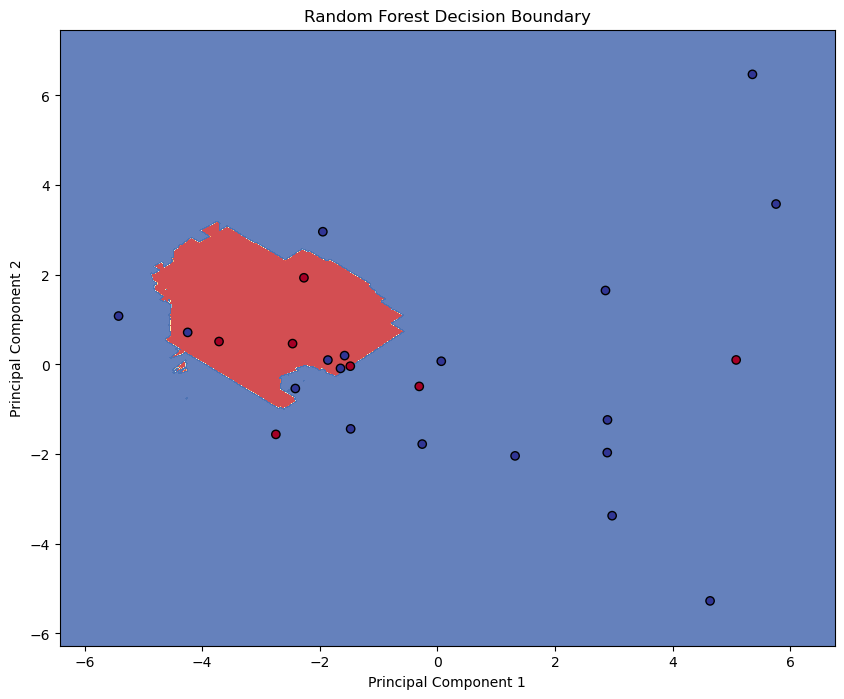

2025-02-21 12:55:09,296 - INFO - Decision boundary plot displayed successfully.
2025-02-21 12:55:09,324 - INFO - 📌 Tuning hyperparameters for Decision Tree...
2025-02-21 12:55:09,325 - INFO - Starting hyperparameter tuning for Decision Tree...
2025-02-21 12:55:09,329 - INFO - Parameter space: {'max_depth': Integer(low=2, high=50, prior='uniform', transform='identity'), 'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'), 'criterion': Categorical(categories=('gini', 'entropy'), prior=None), 'splitter': Categorical(categories=('best', 'random'), prior=None)}
c:\Users\GeoffreyHadfield\Anaconda3\envs\data_science_ml_preprocessor\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\GeoffreyHadfield\Anaconda3\envs\data_science_ml_preprocessor\lib\site-

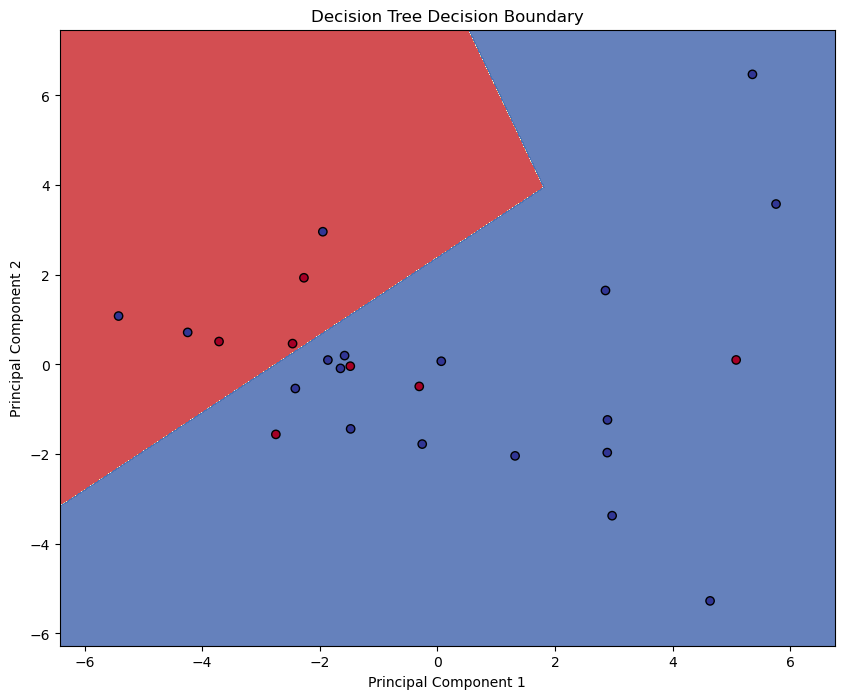

2025-02-21 12:56:21,374 - INFO - Decision boundary plot displayed successfully.
2025-02-21 12:56:21,400 - INFO - ✅ Best model is Random Forest with Log Loss=0.5472680639007826
2025-02-21 12:56:21,480 - INFO - Model saved to C:\Users\GeoffreyHadfield\projects\ml_preprocessor\examples\preprocessor\models\Random_Forest\trained_model.pkl
2025-02-21 12:56:21,480 - INFO - ✅ Model 'Random Forest' saved successfully in 'C:\Users\GeoffreyHadfield\projects\ml_preprocessor\examples\preprocessor\models'.
2025-02-21 12:56:21,483 - INFO - ✅ Tuning results saved to C:\Users\GeoffreyHadfield\projects\ml_preprocessor\examples\preprocessor\models\tuning_results.json.
2025-02-21 12:56:21,485 [INFO] [SUCCESS] Training workflow completed successfully.
2025-02-21 12:56:21,485 - INFO - [SUCCESS] Training workflow completed successfully.


In [18]:
import logging
import json
from typing import Any, Dict
from pathlib import Path
import yaml
import pandas as pd
import joblib  # Ensure joblib is imported

# Local imports - Adjust the import paths based on your project structure
# from datapreprocessor import DataPreprocessor
# from train_utils.train_utils import (
#     evaluate_model, save_model, load_model, plot_decision_boundary,
#     tune_random_forest, tune_xgboost, tune_decision_tree
# )
# from model_factory import get_model

logger = logging.getLogger(__name__)

def load_config(config_path: Path) -> Dict[str, Any]:
    """
    Load configuration from a YAML file.

    Args:
        config_path (Path): Path to the configuration file.

    Returns:
        Dict[str, Any]: Configuration dictionary.
    """
    try:
        with config_path.open('r') as f:
            config = yaml.safe_load(f)
        logger.info(f"✅ Configuration loaded from {config_path}.")
        return config
    except Exception as e:
        logger.error(f"❌ Failed to load configuration: {e}")
        raise

def bayes_best_model_train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    selection_metric: str,
    model_save_dir: Path,
    classification_save_path: Path,
    tuning_results_save: Path,
    selected_models: Any,
    use_pca: bool = False
):
    """
    A streamlined function that:
      1) Tunes and trains models using Bayesian optimization.
      2) Evaluates the best model.
      3) Saves the tuning results and best model.

    Args:
        X_train, y_train: Training features and labels.
        X_test, y_test: Test features and labels.
        selection_metric (str): Metric to select best model (e.g., "Log Loss", "accuracy").
        model_save_dir (Path): Directory to save the best model.
        classification_save_path (Path): Path to save classification report.
        tuning_results_save (Path): Path to save tuning results in JSON format.
        selected_models (list|str): List of models (e.g. ["XGBoost", "Random Forest"]) or a single string.
        use_pca (bool): If True, uses PCA for boundary plotting. Typically False for tree-based models.
    """
    logger.info("Starting the Bayesian hyperparameter tuning process...")

    # Scoring metric selection
    scoring_metric = "neg_log_loss" if selection_metric.lower() == "log loss" else "accuracy"

    # Prepare model registry
    model_registry = {
        # "XGBoost": tune_xgboost,
        "Random Forest": tune_random_forest,
        "Decision Tree": tune_decision_tree
    }

    # Normalize selected_models input
    if isinstance(selected_models, str):
        selected_models = [selected_models]
    elif not selected_models:
        selected_models = list(model_registry.keys())
        logger.info(f"No models specified. Using all available: {selected_models}")

    tuning_results = {}
    best_model_name = None
    best_model = None
    best_metric_value = None

    # Ensure model_save_dir exists
    model_save_dir.mkdir(parents=True, exist_ok=True)
    logger.debug(f"Ensured that the model save directory '{model_save_dir}' exists.")

    # Loop over requested models
    for model_name in selected_models:
        if model_name not in model_registry:
            logger.warning(f"Unsupported model: {model_name}. Skipping.")
            continue
        try:
            logger.info(f"📌 Tuning hyperparameters for {model_name}...")
            tuner_func = model_registry[model_name]

            best_params, best_score, best_estimator = tuner_func(
                X_train, y_train, scoring_metric=scoring_metric
            )
            logger.info(f"✅ {model_name} tuning done. Best Params: {best_params}, Best CV Score: {best_score}")

            # Evaluate on X_test
            metrics = evaluate_model(best_estimator, X_test, y_test, save_path=classification_save_path)
            metric_key = selection_metric.lower().replace(" ", "_")
            metric_value = metrics.get(metric_key)

            if metric_value is not None:
                logger.debug(f"Metric value for {selection_metric}: {metric_value}")
                if best_metric_value is None:
                    best_metric_value = metric_value
                    best_model_name = model_name
                    best_model = best_estimator
                    logger.debug(f"Best model set to {best_model_name} with {selection_metric}={best_metric_value}")
                else:
                    # For log loss, lower is better
                    if selection_metric.lower() == "log loss" and metric_value < best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
                    # For other metrics (accuracy, f1, etc.), higher is better
                    elif selection_metric.lower() != "log loss" and metric_value > best_metric_value:
                        best_metric_value = metric_value
                        best_model_name = model_name
                        best_model = best_estimator
                        logger.debug(f"Best model updated to {best_model_name} with {selection_metric}={best_metric_value}")
            else:
                logger.debug(f"Metric value for {selection_metric} is None. Best model not updated.")

            # Save partial results
            tuning_results[model_name] = {
                "Best Params": best_params,
                "Best CV Score": best_score,
                "Evaluation Metrics": metrics,
            }

            # Plot boundary (optional for tree-based with PCA)
            try:
                plot_decision_boundary(best_estimator, X_test, y_test, f"{model_name} Decision Boundary", use_pca=use_pca)
            except ValueError as e:
                logger.warning(f"Skipping decision boundary plot for {model_name}: {e}")

        except Exception as e:
            logger.error(f"❌ Error tuning {model_name}: {e}")
            continue

    # Save best model information
    if best_model_name:
        logger.info(f"✅ Best model is {best_model_name} with {selection_metric}={best_metric_value}")
        try:
            save_model(best_model, best_model_name, save_dir=model_save_dir)
            logger.info(f"✅ Model '{best_model_name}' saved successfully in '{model_save_dir}'.")
        except Exception as e:
            logger.error(f"❌ Failed to save best model {best_model_name}: {e}")
            raise  # Ensure the exception is propagated

        # Add Best Model info to tuning_results
        tuning_results["Best Model"] = {
            "model_name": best_model_name,
            "metric_value": best_metric_value,
            "path": str(Path(model_save_dir) / best_model_name.replace(" ", "_") / 'trained_model.pkl')
        }
    else:
        logger.warning("⚠️ No best model was selected. Tuning might have failed for all models.")

    # Save tuning results
    try:
        with tuning_results_save.open("w") as f:
            json.dump(tuning_results, f, indent=4)
        logger.info(f"✅ Tuning results saved to {tuning_results_save}.")
    except Exception as e:
        logger.error(f"❌ Error saving tuning results: {e}")


def main():
    # ----------------------------
    # 1. Load Configuration
    # ----------------------------
    config = load_config(Path('../../dataset/test/preprocessor_config/preprocessor_config.yaml'))

    # Extract paths from configuration
    paths_config = config.get('paths', {})
    base_data_dir = Path(paths_config.get('data_dir', '../../dataset/test/data')).resolve()
    raw_data_file = base_data_dir / paths_config.get('raw_data', 'final_ml_dataset.csv')
    processed_data_dir = base_data_dir / paths_config.get('processed_data_dir', 'preprocessor/processed')
    features_metadata_file = base_data_dir / paths_config.get('features_metadata_file', 'features_info/features_metadata.pkl')
    predictions_output_dir = base_data_dir / paths_config.get('predictions_output_dir', 'preprocessor/predictions')
    config_file = Path(paths_config.get('config_file', 'preprocessor_config/preprocessor_config.yaml')).resolve()

    # Output directories
    log_dir = Path(paths_config.get('log_dir', '../preprocessor/logs')).resolve()
    model_save_base_dir = Path(paths_config.get('model_save_base_dir', '../preprocessor/models')).resolve()
    transformers_save_base_dir = Path(paths_config.get('transformers_save_base_dir', '../preprocessor/transformers')).resolve()
    plots_output_dir = Path(paths_config.get('plots_output_dir', '../preprocessor/plots')).resolve()
    training_output_dir = Path(paths_config.get('training_output_dir', '../preprocessor/training_output')).resolve()

    # Initialize Paths for saving
    MODEL_SAVE_DIR = model_save_base_dir
    MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
    CLASSIFICATION_REPORT_PATH = MODEL_SAVE_DIR / "classification_report.txt"
    TUNING_RESULTS_SAVE_PATH = MODEL_SAVE_DIR / "tuning_results.json"


    LOG_FILE = 'training.log'

    SELECTED_MODELS = ["Random Forest"]  # For testing, select a single model
    SELECTION_METRIC = "accuracy"  # Change to "Log Loss" if needed

    # Extract model-related config
    selected_models = config.get('models', {}).get('selected_models', ["XGBoost", "Random Forest", "Decision Tree"])
    selection_metric = config.get('models', {}).get('selection_metric', "Log Loss")

    # Extract Tree Based Classifier options from config
    tree_classifier_options = config.get('models', {}).get('Tree Based Classifier', {})

    # ----------------------------
    # 2. Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, LOG_FILE)
    logger.info("✅ Starting the training module.")

    # ----------------------------
    # 3. Load Data
    # ----------------------------
    try:
        filtered_df = pd.read_csv(raw_data_file)
        logger.info(f"✅ Loaded dataset from {raw_data_file}. Shape: {filtered_df.shape}")
    except FileNotFoundError:
        logger.error(f"❌ Dataset not found at {raw_data_file}.")
        return
    except Exception as e:
        logger.error(f"❌ Failed to load dataset: {e}")
        return

    # Extract feature assets
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }

    # ----------------------------
    # 4. Initialize DataPreprocessor
    # ----------------------------
    # Assuming a supervised classification use case: "Tree Based Classifier"
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=column_assets.get('y_variable', []),
        ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
        nominal_categoricals=column_assets.get('nominal_categoricals', []),
        numericals=column_assets.get('numericals', []), 
        mode='train',
        options=tree_classifier_options,  # The options from config for "Tree Based Classifier"
        debug=config.get('logging', {}).get('debug', False),  # or config-based
        normalize_debug=config.get('execution', {}).get('train', {}).get('normalize_debug', False),
        normalize_graphs_output=config.get('execution', {}).get('train', {}).get('normalize_graphs_output', False),
        graphs_output_dir=plots_output_dir,
        transformers_dir=transformers_save_base_dir
    )

    # ----------------------------
    # 5. Execute Preprocessing
    # ----------------------------
    try:
        # Execute preprocessing by passing the entire filtered_df
        X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(filtered_df)
        print("types of all variables starting with X_train", type(X_train), "X_test type", type(X_test), "y_train type =", type(y_train), "y_test type =", type(y_test),"X_test_inverse type =", type(X_test_inverse))
        logger.info(f"✅ Preprocessing complete. X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    except Exception as e:
        logger.error(f"❌ Error during preprocessing: {e}")
        return

    # ----------------------------
    # 6. Train & Tune the Model
    # ----------------------------
    try:
        bayes_best_model_train(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            selection_metric=selection_metric,
            model_save_dir=MODEL_SAVE_DIR,
            classification_save_path=CLASSIFICATION_REPORT_PATH,
            tuning_results_save=TUNING_RESULTS_SAVE_PATH,
            selected_models=selected_models,
            use_pca=True  
        )
    except Exception as e:
        logger.error(f"❌ Model training/tuning failed: {e}")
        return

    # ----------------------------
    # 7. Completion Message
    # ----------------------------
    logger.info("✅ Training workflow completed successfully.")

if __name__ == "__main__":
    main()

In [19]:
# src/ml/predict.py

import pandas as pd
import logging
import os
import yaml
import joblib
import json
from pathlib import Path
from typing import Any, Dict

# Local imports - Adjust based on your project structure
# from train_utils.train_utils import load_model  # Ensure correct import path
# from datapreprocessor.datapreprocessor import DataPreprocessor  # Uncomment and adjust as necessary

def load_dataset(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

def load_config(config_path: Path) -> Dict[str, Any]:
    if not config_path.exists():
        raise FileNotFoundError(f"Configuration file not found at {config_path}")
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

def setup_logging(log_dir: Path, log_filename: str = 'training.log') -> logging.Logger:
    """Setup logging with proper encoding handling for both file and console output."""
    os.makedirs(log_dir, exist_ok=True)
    log_path = log_dir / log_filename
    
    logger = logging.getLogger('model_training')
    logger.setLevel(logging.INFO)
    
    # Clear existing handlers to prevent duplicate logs
    if logger.hasHandlers():
        logger.handlers.clear()
    
    # Create file handler with UTF-8 encoding
    f_handler = logging.FileHandler(log_path, encoding='utf-8')
    f_handler.setLevel(logging.INFO)
    
    # Create console handler with proper encoding for Windows
    c_handler = logging.StreamHandler()
    c_handler.setLevel(logging.INFO)
    
    # Create formatters and add them to handlers
    # Replace emoji with text alternatives
    class SafeFormatter(logging.Formatter):
        def format(self, record):
            # Replace emojis with text alternatives
            if hasattr(record, 'msg'):
                record.msg = (str(record.msg)
                    .replace('✅', '[SUCCESS]')
                    .replace('❌', '[ERROR]')
                    .replace('⚠️', '[WARNING]'))
            return super().format(record)
    
    formatter = SafeFormatter('%(asctime)s [%(levelname)s] %(message)s')
    f_handler.setFormatter(formatter)
    c_handler.setFormatter(formatter)
    
    # Add handlers to the logger
    logger.addHandler(f_handler)
    logger.addHandler(c_handler)
    
    return logger

def main():
    # ----------------------------
    # Step 1: Load Configuration
    # ----------------------------
    config_path = Path('../../dataset/test/preprocessor_config/preprocessor_config.yaml')  # Adjust as needed
    try:
        config = load_config(config_path)
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        return  # Exit if config loading fails

    # ----------------------------
    # Step 2: Extract Paths from Configuration
    # ----------------------------
    paths = config.get('paths', {})
    data_dir = Path(paths.get('base_data_dir', '../../dataset/test/data')).resolve()
    raw_data_path = data_dir / paths.get('raw_data_file', 'final_ml_dataset.csv')  # Corrected key
    processed_data_dir = data_dir / paths.get('processed_data_dir', 'preprocessor/processed')
    transformers_dir = Path(paths.get('transformers_save_base_dir', '../preprocessor/transformers')).resolve()  # Corrected key
    predictions_output_dir = Path(paths.get('predictions_output_dir', 'preprocessor/predictions')).resolve()
    log_dir = Path(paths.get('log_dir', '../preprocessor/logs')).resolve()
    model_save_dir = Path(paths.get('model_save_base_dir', '../preprocessor/models')).resolve()  # Corrected key
    log_file = paths.get('log_file', 'prediction.log')  # Ensure this key exists in config

    # ----------------------------
    # Step 3: Setup Logging
    # ----------------------------
    logger = setup_logging(log_dir, log_file)
    logger.info("✅ Starting prediction module.")

    # ----------------------------
    # Step 4: Extract Feature Assets
    # ----------------------------
    features_config = config.get('features', {})
    column_assets = {
        'y_variable': features_config.get('y_variable', []),
        'ordinal_categoricals': features_config.get('ordinal_categoricals', []),
        'nominal_categoricals': features_config.get('nominal_categoricals', []),
        'numericals': features_config.get('numericals', [])
    }

    # ----------------------------
    # Step 5: Load Tuning Results to Find Best Model
    # ----------------------------
    tuning_results_path = model_save_dir / "tuning_results.json"
    if not tuning_results_path.exists():
        logger.error(f"❌ Tuning results not found at '{tuning_results_path}'. Cannot determine the best model.")
        return

    try:
        with open(tuning_results_path, 'r') as f:
            tuning_results = json.load(f)
        best_model_info = tuning_results.get("Best Model")
        if not best_model_info:
            logger.error("❌ Best model information not found in tuning results.")
            return
        best_model_name = best_model_info.get("model_name")
        if not best_model_name:
            logger.error("❌ Best model name not found in tuning results.")
            return
        logger.info(f"Best model identified: {best_model_name}")
    except Exception as e:
        logger.error(f"❌ Failed to load tuning results: {e}")
        return

    # ----------------------------
    # Step 6: Preprocess the Data
    # ----------------------------
    # Load Prediction Dataset
    if not raw_data_path.exists():
        logger.error(f"❌ Prediction input dataset not found at '{raw_data_path}'.")
        return

    try:
        df_predict = load_dataset(raw_data_path)
        logger.info(f"✅ Prediction input data loaded from '{raw_data_path}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load prediction input data: {e}")
        return

    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",  # Or dynamically set based on best_model_name if necessary
        y_variable=column_assets.get('y_variable', []),
        ordinal_categoricals=column_assets.get('ordinal_categoricals', []),
        nominal_categoricals=column_assets.get('nominal_categoricals', []),
        numericals=column_assets.get('numericals', []),
        mode='predict',
        options={},  # Adjust based on config or load from somewhere
        debug=False,  # Can be parameterized
        normalize_debug=False,  # As per hardcoded paths
        normalize_graphs_output=False,  # As per hardcoded paths
        graphs_output_dir=Path(paths.get('plots_output_dir', '../preprocessor/plots')).resolve(),
        transformers_dir=transformers_dir
    )

    # Execute Preprocessing for Prediction
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_predict)
        print("X_new_preprocessed type = ", type(X_preprocessed), "X_new_inverse type = ", type(X_inversed))
        logger.info("✅ Preprocessing completed successfully in predict mode.")
    except Exception as e:
        logger.error(f"❌ Preprocessing failed in predict mode: {e}")
        return

    # ----------------------------
    # Step 7: Load the Best Model
    # ----------------------------
    try:
        trained_model = load_model(best_model_name, model_save_dir)
        logger.info(f"✅ Trained model loaded from '{model_save_dir / best_model_name.replace(' ', '_') / 'trained_model.pkl'}'.")
    except Exception as e:
        logger.error(f"❌ Failed to load the best model '{best_model_name}': {e}")
        return

    # ----------------------------
    # Step 8: Make Predictions
    # ----------------------------
    try:
        predictions = trained_model.predict(X_preprocessed)
        logger.info("✅ Predictions made successfully.")
    except Exception as e:
        logger.error(f"❌ Prediction failed: {e}")
        return

    # ----------------------------
    # Step 9: Attach Predictions to Inversed Data
    # ----------------------------
    if X_inversed is not None:
        if len(predictions) == len(X_inversed):
            X_inversed['predictions'] = predictions
            logger.info("✅ Predictions attached to inversed data successfully.")
        else:
            logger.error("❌ Predictions length does not match inversed data length.")
            return
    else:
        logger.error("❌ Inversed data is None. Cannot attach predictions.")
        return

    # ----------------------------
    # Step 10: Save Predictions
    # ----------------------------
    try:
        predictions_output_dir.mkdir(parents=True, exist_ok=True)
        predictions_filename = predictions_output_dir / f'predictions_{best_model_name.replace(" ", "_")}.csv'
        X_inversed.to_csv(predictions_filename, index=False)
        logger.info(f"✅ Predictions saved to '{predictions_filename}'.")
    except Exception as e:
        logger.error(f"❌ Failed to save predictions: {e}")
        return

    logger.info(f"✅ All prediction tasks completed successfully for model '{best_model_name}'.")


if __name__ == "__main__":
    main()

2025-02-21 12:56:21,570 [INFO] [SUCCESS] Starting prediction module.
2025-02-21 12:56:21,570 - INFO - [SUCCESS] Starting prediction module.
2025-02-21 12:56:21,572 [INFO] Best model identified: Random Forest
2025-02-21 12:56:21,572 - INFO - Best model identified: Random Forest
2025-02-21 12:56:21,585 [INFO] [SUCCESS] Prediction input data loaded from 'C:\Users\GeoffreyHadfield\projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv'.
2025-02-21 12:56:21,585 - INFO - [SUCCESS] Prediction input data loaded from 'C:\Users\GeoffreyHadfield\projects\ml_preprocessor\dataset\test\data\final_ml_dataset.csv'.
2025-02-21 12:56:21,587 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-02-21 12:56:21,587 - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.
2025-02-21 12:56:21,588 [INFO] Step: filter_columns
2025-02-21 12:56:21,588 - INFO - Step: filter_columns
2025-02-21 12:56:21,591 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (12

X_new_preprocessed type =  <class 'pandas.core.frame.DataFrame'> X_new_inverse type =  <class 'pandas.core.frame.DataFrame'>
